0.9966105021012356
0.998491135771935
0.7466301880233046
2.217952912418276
0.5898860585718262
4.046654077122932


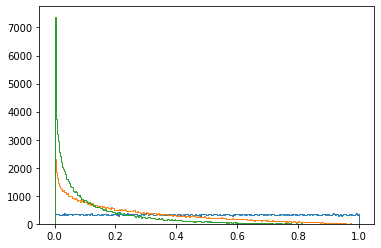

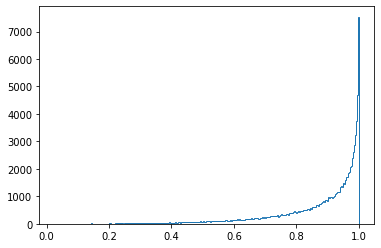

In [1]:
from scipy.stats import beta
import numpy as np
import matplotlib.pyplot as plt

k = 3
z = [np.random.beta(1,1,100000) for i in range(k)]
p = [[np.prod([1 - z[x][n] for x in range(i)]) * z[i][n] for i in range(k)] for n in range(100000)]
p = [[p[i][x] for i in range(100000)] for x in range(k)]
for i in range(k):
    plt.hist(p[i], histtype = u'step', bins = 300)
    a, b, l, s = beta.fit(p[i], floc = 0, fscale = 1)
    print(a)
    print(b)
plt.show()
p_sum = [sum([p[x][i] for x in range(k)]) for i in range(100000)]
plt.hist(p_sum, histtype = u'step', bins = 300)
plt.show()

In [2]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])

from torch import tensor, autograd
import torch

# https://discuss.pytorch.org/t/computing-the-hessian-matrix-correctness-and-performance/53624
def compute_hessian(grads, params):
    H = []
    for i, (grad, p) in enumerate(zip(grads, params)):
        grad = grad.reshape(-1)
        d = len(grad)
        dg = torch.zeros((d, d))

        for j, g in enumerate(grad):
            g2 = autograd.grad(g, p, create_graph=True)[0].view(-1)
            dg[j] = g2

        H.append(dg)

    return H

# based on MGLM
def dgdirmn(Y, alpha, beta): 
    assert beta.shape == alpha.shape

    assert alpha.shape[0] == Y.shape[1] - 1
    alpha = alpha.expand((Y.shape[0], alpha.shape[0]))#     d <- ncol(Y)
    beta = beta.expand((Y.shape[0], beta.shape[0]))#     d <- ncol(Y)

    m = Y.sum(1) #m
    Yrev = Y.T.flip(0) 
    YrevCumsum = Yrev.cumsum(0) 
    z = YrevCumsum.flip(0).T

    n1 = torch.lgamma(m + 1)
    n2 = (torch.lgamma(Y[:, :-1] + alpha)).sum(1)
    n3 = (torch.lgamma(z[:, 1:] + beta)).sum(1)
    n4 = (torch.lgamma(alpha + beta)).sum(1)

    numerator = n1 + n2 + n3 + n4
    
    d1 = torch.lgamma(Y + 1).sum(1)
    d2 = torch.lgamma(alpha).sum(1)
    d3 = torch.lgamma(beta).sum(1)
    d4 = torch.lgamma(alpha + beta + z[:, :-1]).sum(1)

    denominator = d1 + d2 + d3 + d4

    return numerator - denominator

Y = tensor([
    [0, 1, 19],
    [9, 11, 0],
    [0, 0, 20],
    [1, 19, 0],
    [0, 16, 4],
    [2, 14, 4],
    [1, 2, 17],
    [19, 1, 0],
    [2, 16, 2],
    [0, 20, 0]
]).type(torch.float32)

alpha = tensor([0.2, 0.5]).requires_grad_(True)
beta = tensor([0.7, 0.4]).requires_grad_(True)

loss = -dgdirmn(Y, alpha, beta)
sumloss = loss.sum()
# loss.sum().backward()
grads = autograd.grad(sumloss, alpha, create_graph=True)[0]
print('alpha gradient', grads)
sumloss = grads.sum()
grads2 = autograd.grad(sumloss, alpha)[0]
print('alpha hessian', grads2)

grads = autograd.grad(loss.sum(), beta, create_graph=True)[0]
print('beta gradient', grads)
sumloss = grads.sum()
grads2 = autograd.grad(sumloss, beta)[0]
print('beta hessian', grads2)
# print(alpha.grad)
# print(beta.grad)

# print(compute_hessian([alpha.grad, beta.grad], [alpha, beta]))

alpha gradient tensor([ 0.3684, -0.8135], grad_fn=<ViewBackward>)
alpha hessian tensor([135.0201,  23.6215])
beta gradient tensor([-0.8557,  6.6515], grad_fn=<ViewBackward>)
beta hessian tensor([ 8.3107, 24.4226])


In [3]:
# https://discuss.pytorch.org/t/loss-backward-raises-error-grad-can-be-implicitly-created-only-for-scalar-outputs/12152/2
loss.sum().backward()
print(alpha.grad)
print(beta.grad)

tensor([ 0.3684, -0.8135])
tensor([-0.8557,  6.6515])


In [4]:
import torch
from torch import autograd

x = torch.tensor([2., 1.]).requires_grad_(True)
y = 5*x**4 + 3*x**3 + 7*x**2 + 9*x - 5

deriv_x = 5*4*x**3 + 3*3*x**2 + 7*2*x + 9
second_deriv_x = 5*4*3*x**2 + 3*3*2*x + 7*2

loss = y.sum()
# print("derivX", derivX)
deriv = autograd.grad(loss, x, create_graph=True)[0]
loss = deriv.sum()
second_deriv = autograd.grad(loss, x)
print("deriv", deriv, "secondderiv", second_deriv)
print("deriv_x", deriv_x, "second_deriv_x", second_deriv_x)

deriv tensor([233.,  52.], grad_fn=<AddBackward0>) secondderiv (tensor([290.,  92.]),)
deriv_x tensor([233.,  52.], grad_fn=<AddBackward0>) second_deriv_x tensor([290.,  92.], grad_fn=<AddBackward0>)


In [5]:
y

tensor([145.,  19.], grad_fn=<SubBackward0>)

In [6]:
from pyro.distributions import DirichletMultinomial as DM
dm = DM(tensor([[0.1, 0.1, .8], [0.2, 0.5, .3]].T))
dm.log_prob(Y)

AttributeError: 'list' object has no attribute 'T'

In [135]:
Y

tensor([[ 0.,  1., 19.],
        [ 9., 11.,  0.],
        [ 0.,  0., 20.],
        [ 1., 19.,  0.],
        [ 0., 16., 14.],
        [ 2., 14.,  4.],
        [ 1.,  2., 17.],
        [19.,  1.,  0.],
        [ 2., 16.,  2.],
        [ 0., 20.,  0.]])

tensor([[ 1,  3,  5,  7,  9],
        [ 2,  4,  6,  8, 10]])

In [121]:
Y

tensor([[ 0.,  1., 19.],
        [ 9., 11.,  0.],
        [ 0.,  0., 20.],
        [ 1., 19.,  0.],
        [ 0., 16., 14.],
        [ 2., 14.,  4.],
        [ 1.,  2., 17.]])

In [52]:
Y.expand_as(tensor([5,10]))

RuntimeError: expand(torch.FloatTensor{[2, 5]}, size=[2]): the number of sizes provided (1) must be greater or equal to the number of dimensions in the tensor (2)

torch.Size([2, 5])

In [57]:
Y[1,].repeat(tensor([10, 5]))

TypeError: repeat(): argument 'repeats' (position 1) must be tuple of ints, not Tensor

In [65]:
Y[1,].expand_as(10)

TypeError: expand_as(): argument 'other' (position 1) must be Tensor, not int

In [62]:
Y[1,].shape

torch.Size([5])

In [71]:
Y[1,].expand((10,5))

tensor([[ 2.,  4.,  6.,  8., 10.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 2.,  4.,  6.,  8., 10.],
        [ 2.,  4.,  6.,  8., 10.]])

In [42]:
### 
from __future__ import absolute_import, division, print_function

import numbers

import torch
from torch.distributions import constraints
from torch.distributions.utils import broadcast_all

from pyro.distributions.torch import Beta, Binomial, Dirichlet, Gamma, Multinomial, Poisson
from pyro.distributions.torch_distribution import TorchDistribution


def _log_beta(x, y):
    return torch.lgamma(x) + torch.lgamma(y) - torch.lgamma(x + y)


def _log_factorial(x):
    return torch.lgamma(1 + x)

class GeneralizedDirichletMultinomial():
    arg_constraints = {'alphas': constraints.positive, "betas": constraints.positive, 'total_count': constraints.nonnegative_integer}
    support = Multinomial.support

    def __init__(self, alphas, betas, total_count=1, validate_args=None):
        if isinstance(total_count, numbers.Number):
            total_count = concentration.new_tensor(total_count)
        total_count_1 = total_count.unsqueeze(-1)
        alphas, beta, total_count = torch.broadcast_tensors(alphas, betas, total_count_1)
        total_count = total_count_1.squeeze(-1)
        self._dirichlet = Dirichlet(concentration)
        self.total_count = total_count
        super(GeneralizedDirichletMultinomial, self).__init__(
            self._dirichlet._batch_shape, self._dirichlet.event_shape, validate_args=validate_args)

    @property
    def concentration(self):
        return self._dirichlet.concentration

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(DirichletMultinomial, _instance)
        batch_shape = torch.Size(batch_shape)
        new._dirichlet = self._dirichlet.expand(batch_shape)
        new.total_count = self.total_count.expand(batch_shape)
        super(DirichletMultinomial, new).__init__(
            new._dirichlet.batch_shape, new._dirichlet.event_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def sample(self, sample_shape=()):
        probs = self._dirichlet.sample(sample_shape)
        total_count = int(self.total_count.max())
        if not self.total_count.min() == total_count:
            raise NotImplementedError("Inhomogeneous total count not supported by `enumerate_support`.")
        return Multinomial(total_count, probs).sample()

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        n = self.total_count
        alpha = self.concentration
        alpha_sum = self.concentration.sum(-1)
        return (_log_factorial(n) + torch.lgamma(alpha_sum) - torch.lgamma(n + alpha_sum) +
                (torch.lgamma(value + alpha) - _log_factorial(value) - torch.lgamma(alpha)).sum(-1))

    @property
    def mean(self):
        return self._dirichlet.mean * self.total_count.unsqueeze(-1)

    @property
    def variance(self):
        n = self.total_count.unsqueeze(-1)
        alpha = self.concentration
        alpha_sum = self.concentration.sum(-1, keepdim=True)
        alpha_ratio = alpha / alpha_sum
        return n * alpha_ratio * (1 - alpha_ratio) * (n + alpha_sum) / (1 + alpha_sum)

In [80]:
Y.shape

torch.Size([7, 3])

In [ ]:
### 
from __future__ import absolute_import, division, print_function

import numbers

import torch
from torch.distributions import constraints
from torch.distributions.utils import broadcast_all

from pyro.distributions.torch import Beta, Binomial, Dirichlet, Gamma, Multinomial, Poisson
from pyro.distributions.torch_distribution import TorchDistribution


def _log_beta(x, y):
    return torch.lgamma(x) + torch.lgamma(y) - torch.lgamma(x + y)


def _log_factorial(x):
    return torch.lgamma(1 + x)

class GeneralizedDirichletMultinomial(TorchDistribution):
    r"""
    TODO: FIX
    Compound distribution comprising of a dirichlet-multinomial pair. The probability of
    classes (``probs`` for the :class:`~pyro.distributions.Multinomial` distribution)
    is unknown and randomly drawn from a :class:`~pyro.distributions.Dirichlet`
    distribution prior to a certain number of Categorical trials given by
    ``total_count``.

    :param float or torch.Tensor concentration: concentration parameter (alpha) for the
        Dirichlet distribution.
    :param int or torch.Tensor total_count: number of Categorical trials.
    """
    arg_constraints = {'alphas': constraints.positive, "betas": constraints.positive, 'total_count': constraints.nonnegative_integer}
    support = Multinomial.support

    def __init__(self, alphas, betas, total_count=1, validate_args=None):
        if isinstance(total_count, numbers.Number):
            total_count = concentration.new_tensor(total_count)
        total_count_1 = total_count.unsqueeze(-1)
        alphas, beta, total_count = torch.broadcast_tensors(alphas, betas, total_count_1)
        total_count = total_count_1.squeeze(-1)
        self._dirichlet = Dirichlet(concentration)
        self.total_count = total_count
        super(GeneralizedDirichletMultinomial, self).__init__(
            self._dirichlet._batch_shape, self._dirichlet.event_shape, validate_args=validate_args)

    @property
    def concentration(self):
        return self._dirichlet.concentration

    def expand(self, batch_shape, _instance=None):
        new = self._get_checked_instance(DirichletMultinomial, _instance)
        batch_shape = torch.Size(batch_shape)
        new._dirichlet = self._dirichlet.expand(batch_shape)
        new.total_count = self.total_count.expand(batch_shape)
        super(DirichletMultinomial, new).__init__(
            new._dirichlet.batch_shape, new._dirichlet.event_shape, validate_args=False)
        new._validate_args = self._validate_args
        return new

    def sample(self, sample_shape=()):
        probs = self._dirichlet.sample(sample_shape)
        total_count = int(self.total_count.max())
        if not self.total_count.min() == total_count:
            raise NotImplementedError("Inhomogeneous total count not supported by `enumerate_support`.")
        return Multinomial(total_count, probs).sample()

    def log_prob(self, value):
        if self._validate_args:
            self._validate_sample(value)
        n = self.total_count
        alpha = self.concentration
        alpha_sum = self.concentration.sum(-1)
        return (_log_factorial(n) + torch.lgamma(alpha_sum) - torch.lgamma(n + alpha_sum) +
                (torch.lgamma(value + alpha) - _log_factorial(value) - torch.lgamma(alpha)).sum(-1))

    @property
    def mean(self):
        return self._dirichlet.mean * self.total_count.unsqueeze(-1)

    @property
    def variance(self):
        n = self.total_count.unsqueeze(-1)
        alpha = self.concentration
        alpha_sum = self.concentration.sum(-1, keepdim=True)
        alpha_ratio = alpha / alpha_sum
        return n * alpha_ratio * (1 - alpha_ratio) * (n + alpha_sum) / (1 + alpha_sum)

In [16]:
from torch import tensor
import torch
alphas  = tensor([1., 2, 3, 4, 5])
betas =   tensor([0.1, 3, 6, 9, 12])


tensor(0.0252)

In [34]:
def dmdMean(alphas, betas):
    # E\left(X_{j}\right)={\frac  {\alpha _{j}}{\alpha _{j}+\beta _{j}}}\prod _{{m=1}}^{{j-1}}{\frac  {\beta _{m}}{\alpha _{m}+\beta _{m}}}.
    # TODO: precalcc
    a_is = [i for i in range(len(alphas))]
    b_is = [len(alphas) - i for i in range(len(alphas), 0, -1)] 

    print(a_is)
    print(b_is)

    # beta_prod = torch.prod(betas[:-1] / (alphas[:-1] + betas[:-1]))
    # denom_pod = torch.prod(alphas[:-1] + betas[:-1])

    # B_1 * B_2 * ... B_n-1 / ( (A_1 + B_1) * (A_2) * B_2)

In [35]:
dmdMean(alphas, betas)

[0, 1, 2, 3, 4]
[0, 1, 2, 3, 4]


In [25]:
len(alphas)

5

tensor([[0.1000, 0.0400],
        [0.0400, 0.1000]])

In [40]:
mvn = MVN(tensor([0., 0.]), covMatrix)

In [156]:
!pip install torch
!pip install numpy

from torch.distributions import MultivariateNormal as MVN
from torch.distributions import Normal as N
from torch import Tensor
import numpy as np
def sampleNonNegative(mean: Tensor, cov: Tensor):
    mvn = MVN(mean, cov)
    samples = mvn.sample()

    for sample in samples:
        if sample < 0:
            return sampleNonNegative(mean, cov)

    return samples

def sampleNnonNeg(N: int, mean: Tensor, cov: Tensor):
    print("mean", mean)
    res = []
    for i in range(N):
        n = sampleNonNegative(mean, cov)
        res.append(n.numpy())

    return tensor(res)


def getTargetMeanEffect(PD: Tensor, rrTarget: Tensor):
    norm = N(0, 1)
    pdThresh = norm.icdf(1 - PD)
    pdTarget = PD * rrTarget
    print("pdThresh", pdThresh)
    print("pdTarget", pdTarget)
    pdvthresh = norm.icdf(1 - pdTarget)
    print("pdvthresh", pdvthresh)
    meanEffect = pdThresh - pdvthresh
    print("meanEffect", meanEffect)
    return meanEffect

corrMatrixSingle = tensor( [ [1, 0], [0, 1] ])
covMatrixSingle = corrMatrixSingle * .01
corrMatrx = tensor( [ [1, .4], [.4, 1] ])
covMatrix = corrMatrx * .01
covMatrix

norm = N(0, 1)
pdBoth = tensor(0.002)
pds = tensor([.01, .01])
rrMeans = tensor([3, 5])

targetMeanEffects = getTargetMeanEffect(pds, rrMeans)
print("targetMeanEffects", targetMeanEffects)
testSampleRestricted = sampleNnonNeg(1000, targetMeanEffects, covMatrix)
totalRestricted = testSampleRestricted[:, 0] + testSampleRestricted[:, 1]

pdsThresh = norm.icdf(1 - pds)
print("pdsThresh", pdsThresh)
pdBothThresh = norm.icdf(1 - pdBoth)
print("testSampleRestricted", testSampleRestricted)
PDOneGivenBothAffectedThresh = pdsThresh - testSampleRestricted
print("PDOneGivenBothAffectedThresh", PDOneGivenBothAffectedThresh)
PDBothGivenBothAffectedThresh = pdBothThresh - totalRestricted
PDoneGivenV = 1 - norm.cdf(PDOneGivenBothAffectedThresh)
PDbothGivenV = 1 - norm.cdf(PDBothGivenBothAffectedThresh)

PDVs = torch.stack([*PDoneGivenV.T,PDbothGivenV]).T

print(PDoneGivenV.mean(0) / pds)
print(PDbothGivenV.mean(0) / pdBoth)

# print("pdBothThresh", pdBothThresh)
# print("PDBothGivenVthreshold", PDBothGivenVthreshold)
# print("totalRestricted", totalRestricted)
# print("PDbothGivenV", PDbothGivenV)
# norm.cdf(PDBothGivenVthreshold.mean())

pdThresh tensor([2.3263, 2.3263])
pdTargettensor([0.0300, 0.0500])
pdvthresh tensor([1.8808, 1.6449])
meanEffect tensor([0.4456, 0.6815])
targetMeanEffects tensor([0.4456, 0.6815])
mean tensor([0.4456, 0.6815])
pdsThresh tensor([2.3263, 2.3263])
testSampleRestricted tensor([[0.3423, 0.7485],
        [0.3037, 0.6233],
        [0.4808, 0.6610],
        ...,
        [0.4155, 0.5862],
        [0.3882, 0.6279],
        [0.4160, 0.7017]])
PDonlyOneGivenVthreshold tensor([[1.9841, 1.5778],
        [2.0226, 1.7030],
        [1.8455, 1.6653],
        ...,
        [1.9108, 1.7402],
        [1.9382, 1.6984],
        [1.9103, 1.6246]])
tensor([3.0564, 5.1171])
tensor(21.0731)


In [157]:
targetMeanEffects = getTargetMeanEffect(pds, rrMeans)

print("targetMeanEffects", targetMeanEffects)
meanEffects = sampleNnonNeg(1000, targetMeanEffects, covMatrixSingle)
nullEffects = sampleNnonNeg(1000, tensor([0., 0.]), covMatrixSingle)
print("mean effects means", meanEffects.mean(0))
print("null effects means", nullEffects.mean(0))
# print("(meanEffects/nullEffects).mean(0)", (nullEffects).mean(0))

pdsThresh = norm.icdf(1 - pds)
pdBothThresh = norm.icdf(1 - pdBoth)

PDVonlyOneThresh = pdsThresh - meanEffects
PDVBothIn1Thresh = pdBothThresh - meanEffects[:, 0]
PDVBothIn2Thresh = pdBothThresh - meanEffects[:, 1]

pds1only = tensor

PDVonlyOne = 1 - norm.cdf(PDVonlyOneThresh)
PDBothIn1 = 1 - norm.cdf(PDVBothIn1Thresh)
PDBothIn2 = 1 - norm.cdf(PDVBothIn2Thresh)

print("PDVonlyOne", PDVonlyOne)
print("PDBothIn1", PDBothIn1)
print("PDBothIn2", PDBothIn2)

pdThresh tensor([2.3263, 2.3263])
pdTarget tensor([0.0300, 0.0500])
pdvthresh tensor([1.8808, 1.6449])
meanEffect tensor([0.4456, 0.6815])
targetMeanEffects tensor([0.4456, 0.6815])
mean tensor([0.4456, 0.6815])
mean tensor([0., 0.])
mean effects means tensor([0.4441, 0.6852])
null effects means tensor([0.0813, 0.0781])
PDVonlyOne tensor([[0.0295, 0.0476],
        [0.0458, 0.0577],
        [0.0247, 0.0435],
        ...,
        [0.0263, 0.0643],
        [0.0255, 0.0467],
        [0.0339, 0.0544]])
PDBothIn1 tensor([0.0073, 0.0126, 0.0059, 0.0103, 0.0070, 0.0078, 0.0077, 0.0078, 0.0112,
        0.0061, 0.0095, 0.0072, 0.0098, 0.0061, 0.0091, 0.0108, 0.0072, 0.0040,
        0.0123, 0.0078, 0.0108, 0.0101, 0.0055, 0.0133, 0.0097, 0.0087, 0.0051,
        0.0055, 0.0059, 0.0044, 0.0083, 0.0084, 0.0060, 0.0097, 0.0052, 0.0075,
        0.0097, 0.0047, 0.0059, 0.0074, 0.0065, 0.0066, 0.0139, 0.0090, 0.0057,
        0.0077, 0.0113, 0.0103, 0.0052, 0.0084, 0.0075, 0.0081, 0.0066, 0.0051,
       

In [161]:
pds[0].expand(PDVonlyOne.shape[0],1).shape

torch.Size([1000, 1])

In [193]:
# We have different sample prevalences for each condition
# so while the underlying mean effect is the same (? is it?), the threshold after subtracting
#  mean effect from prevalence will be different
d1affected = torch.stack([PDVonlyOne[:,0], pds[1].expand(PDVonlyOne.shape[0]), PDBothIn1]).T
d2affected = torch.stack([pds[0].expand(PDVonlyOne.shape[0]), PDVonlyOne[:,1], PDBothIn2]).T
bothAffected = torch.stack([*PDoneGivenV.T, PDbothGivenV]).T
print("d1affected", d1affected.shape)
print("d2affected", d2affected.mean(0))
print("bothAffected", bothAffected.mean(0))

torch.stack([d1affected, d2affected, bothAffected]).transpose(1,0)[0][1].shape[0]

d1affected torch.Size([1000, 3])
d2affected tensor([0.0100, 0.0512, 0.0145])
bothAffected tensor([0.0306, 0.0512, 0.0421])


3

In [176]:
torch.stack([*PDoneGivenV.T,PDbothGivenV])[0].shape

torch.Size([1000])

In [97]:
print(PDbothGivenV.shape)
print(PDoneGivenV.shape)

print(PDbothGivenV.unsqueeze(1).shape)


torch.Size([1000])
torch.Size([1000, 2])
torch.Size([1000, 1])


In [131]:
print(PDVonlyOne.T)

tensor([[0.0494, 0.0997, 0.0297,  ..., 0.0183, 0.0486, 0.0423],
        [0.0629, 0.0433, 0.0287,  ..., 0.0225, 0.0280, 0.1117]])


In [88]:
tensor([*PDoneGivenV.numpy()])

tensor([[0.0302, 0.0473],
        [0.0473, 0.0169],
        [0.0455, 0.0937],
        ...,
        [0.0774, 0.0573],
        [0.0191, 0.0244],
        [0.0265, 0.0284]])

In [164]:
# testSample = MVN(targetMeanEffects, covMatrix).sample([10000])
# total = testSample.sum(1)
# print(total.shape)



tensor([2.2658, 2.2350])
tensor(20.0966)


In [144]:
print(np.corrcoef(testSample[:,0],testSample[:,1]))
print(np.corrcoef(testSampleRestricted[:, 0], testSampleRestricted[:, 1]))

[[1.         0.41538405]
 [0.41538405 1.        ]]
[[1.         0.19302006]
 [0.19302006 1.        ]]


In [145]:
print(np.corrcoef(total, testSample[:,0]))
print(np.corrcoef(totalRestricted, testSampleRestricted[:,0]))

[[1.         0.84317885]
 [0.84317885 1.        ]]
[[1.         0.77480946]
 [0.77480946 1.        ]]


In [146]:
testSample.mean(0)

tensor([0.3029, 0.3019])

In [87]:
total = samples.sum()

In [88]:
total

tensor(0.3262)

In [96]:
n = N(0, 1)
PD = tensor(.05)

In [97]:
threshold = n.icdf(1- PD)

In [98]:
new_threshold = threshold - total

In [99]:
n.cdf(new_threshold)

tensor(0.9064)

In [100]:
pd1_thresh = threshold - samples[0]
pd1 = 1 - n.cdf(pd1_thresh)
pd1

tensor(0.0706)

In [101]:
pd1

tensor(0.0706)

In [46]:
# rr1 = tensor(3.)
# pd1est = PD * rr1
# pd1est

# # I need something that goes from any Prevalence, and increases it by 3x, roughly
# PD = tensor(.01)
# PDtarget = rr1 * PD
# print(PDtarget)
# threshold_pd = n.icdf(1 - PD)
# threshold_pd1 = n.icdf(1 - PDtarget)
# print(threshold_pd1)
# print(threshold_pd)

NameError: name 'PD' is not defined

In [116]:
n.cdf(threshold_pd1)

tensor(0.9700)

In [117]:
n.cdf(threshold_pd)

tensor(0.9900)

In [111]:
threshold_pd1

tensor(1.8808)

In [32]:
from torch import tensor
res = genData.genAlleleCountFromPDVS(tensor(), tensor([.03, .03, .004]), 1e-4, pDs = tensor([.01,.01,.002]))
res

probVgivenNotD tensor(9.5706e-05)
pDs tensor([0.0100, 0.0100, 0.0020]) 1-pDs.sum() tensor(0.9780)
p tensor([9.3600e-05, 3.0000e-06, 3.0000e-06, 4.0000e-07])


(tensor([28.,  0.,  5.,  0.]),
 tensor([9.3600e-05, 3.0000e-06, 3.0000e-06, 4.0000e-07]))

In [37]:
res[0].mean(0)

tensor(8.2500)

In [40]:
resOld = genData.genAlleleCount(tensor(3.3e5), rrs = tensor([3, 3, 2]), afMean = 1e-4, pDs = tensor([.01,.01,.002]))
resOld[0].mean(1)

probVgivenDs tensor([0.0003, 0.0003, 0.0002])
probVgivenNotD tensor(9.5706e-05)
pDs tensor([0.0100, 0.0100, 0.0020]) 1-pDs.sum() tensor(0.9780)
probVgivenDs*pDs tensor([3.0000e-06, 3.0000e-06, 4.0000e-07])
p tensor([9.3600e-05, 3.0000e-06, 3.0000e-06, 4.0000e-07])


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [8]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [9]:
from mvl import genData, likelihoods, bayes, popgen
from mvl.likelihoods import getAlphas, getPis
from torch import tensor

In [146]:
# liabParams = {"pDs": tensor([.01, .01, .002])}
liabParams23 = genData.genParams(pis=tensor([.1, .1, .1]), rrMeans=tensor([10., 10.]), afMean = tensor(1e-4), pDs = tensor([.01, .01]), afShape=tensor(50.), nCases=tensor([1.5e4, 1.5e4, 4e3]), nCtrls=tensor(5e4), covShared=tensor([ [1., .5], [.5, 1] ]), meanEffectCovarianceScale=tensor(.001))
print("liabParams23", liabParams23)
liabData23 = genData.v6liability(**liabParams23[0])
liabParams23[0]["pDs"] = liabData23["PDs"] #TODO: normalized names, and indicate that the params pDs are incomplete

liabParams23 [{'nGenes': 20000, 'nCases': tensor([15000., 15000.,  4000.]), 'nCtrls': tensor(50000.), 'pDs': tensor([0.0100, 0.0100]), 'diseaseFractions': tensor([0.1000, 0.1000, 0.1000]), 'rrShape': tensor(10.), 'rrMeans': tensor([10., 10.]), 'afShape': tensor(50.), 'afMean': tensor(1.0000e-04), 'covShared': tensor([[1.0000, 0.9500],
        [0.9500, 1.0000]]), 'covSingle': tensor([[1, 0],
        [0, 1]]), 'meanEffectCovarianceScale': tensor(0.0010), 'rrtype': 'default'}]
pDs tensor([0.0100, 0.0100])
thresh1, thresh2 tensor(-2.3263) tensor(-2.3263)
covShared tensor([[1.0000, 0.9500],
        [0.9500, 1.0000]])
pDsWithBoth tensor([0.0100, 0.0100, 0.0067], dtype=torch.float64)
PDBoth tensor(0.0067, dtype=torch.float64)
pdThresh tensor([2.3263, 2.3263])
pdTarget tensor([0.1000, 0.1000])
pdvthresh tensor([1.2816, 1.2816])
meanEffect tensor([1.0448, 1.0448])
meanEffectsAcrossAllGenes tensor([1.0448, 1.0448])
allEffects tensor([[-1.0375, -1.0464],
        [-1.0232, -1.0220],
        [-1.03

In [139]:
likelihoods.getAltCountMeans(liabData23, liabParams23[0])

[tensor([9.3543e-05, 9.5042e-05, 9.4524e-05, 9.1567e-05], dtype=torch.float64),
 tensor([9.2505e-05, 2.9397e-04, 9.5891e-05, 2.2803e-03], dtype=torch.float64),
 tensor([9.3418e-05, 9.7806e-05, 2.8959e-04, 2.2577e-03], dtype=torch.float64),
 tensor([9.2633e-05, 2.8939e-04, 2.8805e-04, 7.2937e-05], dtype=torch.float64)]

In [ ]:
liabData23["altCounts"][liabData23["affectedGenes"][2]].mean(0)

In [132]:
liabData23["afs"][liabData23["affectedGenes"][0]].std(0)

tensor([7.8055e-06, 8.3902e-06, 2.4642e-06, 1.7291e-05], dtype=torch.float64)

In [ ]:
liabData23["afs"][liabData23["affectedGenes"][0]].mean(0)

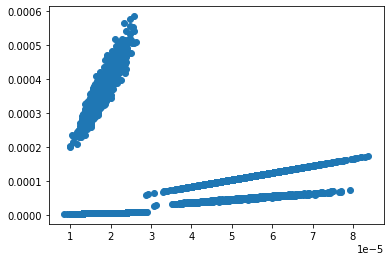

In [129]:
# liabData23["afs"][: 1:]
# plt.plot(liabData23["afs"][:2:])
plt.scatter(liabData23["afs"][:, 1], liabData23["afs"][:, 3])

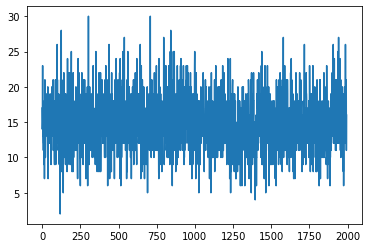

In [135]:
plt.plot(liabData23["altCounts"][liabData23["affectedGenes"][1]][:,2])

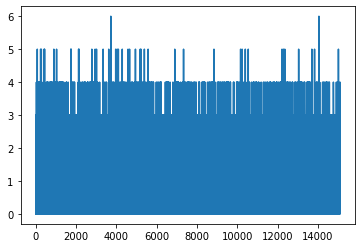

In [83]:
plt.plot(liabData23["altCounts"][liabData23["unaffectedGenes"]][:,2])

In [1163]:
liabData23["altCounts"][liabData23["unaffectedGenes"]][:,2].std(0)

tensor(1.1014, dtype=torch.float64)

In [1172]:
liabData23["altCounts"][liabData23["affectedGenes"][1]][:,2].mean(0)

tensor(4.3442, dtype=torch.float64)

In [1173]:
liabData23["altCounts"][liabData23["affectedGenes"][2]][:,2].mean(0)

tensor(4.3151, dtype=torch.float64)

In [1119]:
testFitLiab23 = likelihoods.fitFnBivariate(liabData23["altCounts"], liabParams23[0]["pDs"], liabParams23[0]["nCases"], liabParams23[0]["nCtrls"], nEpochs=1)

torch.Size([20001, 4])
n tensor([ 8., 11.,  8.,  ..., 12.,  8.,  8.], dtype=torch.float64)
pdsAll tensor([0.5952, 0.1786, 0.1786, 0.0476])
pdsAllPop tensor([0.9613, 0.0100, 0.0100, 0.0187], dtype=torch.float64)
pDS are tensor([0.5952, 0.1786, 0.1786, 0.0476])
altCounts are tensor([[8., 0., 0., 0.],
        [3., 1., 7., 0.],
        [4., 3., 0., 1.],
        ...,
        [3., 3., 6., 0.],
        [5., 2., 1., 0.],
        [5., 2., 1., 0.]], dtype=torch.float64)
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9d7701da70>
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9d7701da70>
fnArgs [0.008475529, 0.006891523, 0.013504546, 8237.842, 11037.951, 19635.277, 24704.588]
ll tensor(80905.8423, dtype=torch.float64)
fnArgs [0.0068882853, 0.08547275, 0.12397033, 4558.369, 3721.069, 1071.3583, 10770.296]
ll tensor(82427.8491, dtype=torch.float64)
fnArgs [0.085646465, 0.033169076, 0.105241366, 23697.844, 3583.71

In [1139]:
testFitLiab23["params"]

tensor([0.0100, 0.0100], dtype=torch.float64)

In [1770]:
liabParams55 = genData.genParams(pis=tensor([.1, .1, .05]), rrMeans=tensor([2., 2.]), afMean = tensor(1e-4), pDs = tensor([.01, .01]), afShape=tensor(50.), nCases=tensor([1.5e4, 1.5e4, 4e3]), nCtrls=tensor(5e4), covShared=tensor([ [1, .5], [.5, 1] ]), meanEffectCovarianceScale=tensor(.001))[0]
liabParams55["pDs"] = liabParams55["pDs"][0:2]
liabData55 = genData.v6liability(**liabParams55)
liabParams55["pDs"] = liabData55["PDs"] #TODO: normalized names, and indicate that the params pDs are incomplete

pDs tensor([0.0100, 0.0100])
thresh1, thresh2 tensor(2.3263) tensor(2.3263)
covShared tensor([[1.0000, 0.5000],
        [0.5000, 1.0000]])
pDsWithBoth tensor([0.0100, 0.0100, 0.0087])
PDBoth tensor(0.0087)
pdThresh tensor([2.3263, 2.3263])
pdTarget tensor([0.0200, 0.0200])
pdvthresh tensor([2.0537, 2.0537])
meanEffect tensor([0.2726, 0.2726])
meanEffectsAcrossAllGenes tensor([0.2726, 0.2726])
allEffects tensor([[0.3379, 0.3179],
        [0.2730, 0.2474],
        [0.2790, 0.2967],
        ...,
        [0.2399, 0.2848],
        [0.2353, 0.2942],
        [0.3402, 0.3526]])
PD1GivenV tensor(0.0270) PD2GivenV tensor(0.0275)
PDBothGivenV.max tensor(0.0487, dtype=torch.float64)
pdsCovarOnMean.mean(0) tensor([0.0200, 0.0200, 0.0367], dtype=torch.float64)
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,1])
 [[1.         0.50116849]
 [0.50116849 1.        ]]
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,2])
 [[1.         0.86622337]
 [0.86622337 1.        ]]
PD1GivenV tensor([0.0217, 0.021

In [1777]:
liabData55["afs"][liabData55["unaffectedGenes"]].mean(0)

tensor([5.9524e-05, 1.7857e-05, 1.7857e-05, 4.7619e-06], dtype=torch.float64)

In [1377]:
likelihoods.getAltCountMeans(liabData55, liabParams55)

[tensor([0.0005, 0.0005, 0.0005, 0.0005], dtype=torch.float64),
 tensor([0.0005, 0.0010, 0.0005, 0.0012], dtype=torch.float64),
 tensor([0.0005, 0.0005, 0.0010, 0.0012], dtype=torch.float64),
 tensor([0.0005, 0.0010, 0.0010, 0.0021], dtype=torch.float64)]

In [1385]:
liabParams55

{'nGenes': 20000,
 'nCases': tensor([15000., 15000.,  4000.]),
 'nCtrls': tensor(50000.),
 'pDs': tensor([0.0100, 0.0100, 0.0087]),
 'diseaseFractions': tensor([0.1000, 0.1000, 0.0500]),
 'rrShape': tensor(10.),
 'rrMeans': tensor([2., 2.]),
 'afShape': tensor(50.),
 'afMean': tensor(0.0005),
 'covShared': tensor([[1.0000, 0.5000],
         [0.5000, 1.0000]]),
 'covSingle': tensor([[1, 0],
         [0, 1]]),
 'meanEffectCovarianceScale': tensor(0.0100),
 'rrtype': 'default'}

In [1769]:
liabData55["altCounts"][liabData55["affectedGenes"][2]].mean(0)

tensor([4.6890, 2.8943, 2.8984, 1.0020], dtype=torch.float64)

In [1379]:
liabData55["altCounts"][liabData55["unaffectedGenes"]].mean(0)

tensor([24.9955,  7.5142,  7.4859,  2.0044], dtype=torch.float64)

In [1380]:
testFitLiab55new = likelihoods.fitFnBivariate(liabData55["altCounts"], liabData55["PDs"], liabParams55["nCases"], liabParams55["nCtrls"], nEpochs=1)

torch.Size([20001, 4])
pDs in likelihoodBivariateFast tensor([0.0100, 0.0100, 0.0087])
n tensor([42., 42., 42.,  ..., 53., 49., 49.], dtype=torch.float64)
pdsAll tensor([0.5952, 0.1786, 0.1786, 0.0476])
pdsAllPop tensor([0.9713, 0.0100, 0.0100, 0.0087])
pDS are tensor([0.5952, 0.1786, 0.1786, 0.0476])
altCounts are tensor([[21.,  6., 13.,  2.],
        [32.,  3.,  6.,  1.],
        [23.,  7.,  9.,  3.],
        ...,
        [20., 23.,  7.,  3.],
        [25.,  7., 15.,  2.],
        [25.,  7., 15.,  2.]], dtype=torch.float64)
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9cd805ca70>
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9cd805ca70>
fnArgs [0.14829823, 0.1484919, 0.14232898, 212.05093, 146.41974, 385.6818, 203.1874]
ll tensor(148294.5343, dtype=torch.float64)
fnArgs [0.30196956, 0.033684347, 0.057479084, 246.43349, 157.90515, 430.38742, 485.77356]
ll tensor(149780.4930, dtype=torch.float64)

In [1381]:
testFitLiab55new["params"]

[array([8.99168924e-02, 9.35269820e-02, 5.20697097e-02, 2.19123498e+02,
        5.07692321e+02, 5.07506472e+02, 1.03620164e+03])]

In [1382]:
testFitLiab55 = likelihoods.fitFnBivariate(liabData55["altCounts"], liabData55["PDs"], liabParams55["nCases"], liabParams55["nCtrls"], nEpochs=1, old=True)

torch.Size([20001, 4])
pDs in likelihoodBivariateFast tensor([0.0100, 0.0100, 0.0087])
n tensor([42., 42., 42.,  ..., 53., 49., 49.], dtype=torch.float64)
pdsAll tensor([0.5952, 0.1786, 0.1786, 0.0476])
pdsAllPop tensor([0.9713, 0.0100, 0.0100, 0.0087])
pDS are tensor([0.5952, 0.1786, 0.1786, 0.0476])
altCounts are tensor([[21.,  6., 13.,  2.],
        [32.,  3.,  6.,  1.],
        [23.,  7.,  9.,  3.],
        ...,
        [20., 23.,  7.,  3.],
        [25.,  7., 15.,  2.],
        [25.,  7., 15.,  2.]], dtype=torch.float64)
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9db0fbb710>
In main function
Running old
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihoodOld at 0x7f9da5f36200>
fnArgs [0.14475803, 0.0125592565, 0.09453185, 414.6404, 355.17603, 276.00797, 342.18964]
ll tensor(144942.8230, dtype=torch.float64)
fnArgs [0.034315217, 0.13243164, 0.20955397, 474.23395, 163.96582, 104.84783, 448.88712]
ll tensor(149506.7856, dt

In [1384]:
testFitLiab55["params"]

[array([8.94523131e-02, 9.34730328e-02, 5.28155902e-02, 2.17335139e+02,
        5.04143205e+02, 5.03763267e+02, 2.58105920e-10])]

In [1391]:
liabParams55cov = genData.genParams(pis=tensor([.1, .1, .05]), rrMeans=tensor([2., 2.]), afMean = tensor(5e-4), pDs = tensor([.01, .01]), afShape=tensor(50.), nCases=tensor([1.5e4, 1.5e4, 4e3]), nCtrls=tensor(5e4), covShared=tensor([ [1, .95], [.95, 1] ]), meanEffectCovarianceScale=tensor(.01))[0]
liabParams55cov["pDs"] = liabParams55cov["pDs"][0:2]
liabData55cov = genData.v6liability(**liabParams55cov)
liabParams55cov["pDs"] = liabData55cov["PDs"] #TODO: normalized names, and indicate that the params pDs are incomplete

pDs tensor([0.0100, 0.0100])
thresh1, thresh2 tensor(2.3263) tensor(2.3263)
covShared tensor([[1.0000, 0.9500],
        [0.9500, 1.0000]])
pDsWithBoth tensor([0.0100, 0.0100, 0.0033])
PDBoth tensor(0.0033)
pdThresh tensor([2.3263, 2.3263])
pdTarget tensor([0.0200, 0.0200])
pdvthresh tensor([2.0537, 2.0537])
meanEffect tensor([0.2726, 0.2726])
meanEffectsAcrossAllGenes tensor([0.2726, 0.2726])
allEffects tensor([[0.2885, 0.2954],
        [0.2799, 0.3174],
        [0.1750, 0.1797],
        ...,
        [0.3944, 0.3891],
        [0.3220, 0.2953],
        [0.1183, 0.0982]])
PD1GivenV tensor(0.0481) PD2GivenV tensor(0.0478)
PDBothGivenV.max tensor(0.0595, dtype=torch.float64)
pdsCovarOnMean.mean(0) tensor([0.0205, 0.0205, 0.0266], dtype=torch.float64)
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,1])
 [[1.         0.94911894]
 [0.94911894 1.        ]]
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,2])
 [[1.         0.98714807]
 [0.98714807 1.        ]]
PD1GivenV tensor([0.0197, 0.014

In [1415]:
liabData55cov["altCounts"][liabData55cov["affectedGenes"][0]].mean(0)

tensor([24.2875, 15.2143,  7.4429, 12.1808], dtype=torch.float64)

In [1392]:
testFitLiab55covNew = likelihoods.fitFnBivariate(liabData55cov["altCounts"], liabData55cov["PDs"], liabParams55cov["nCases"], liabParams55cov["nCtrls"], nEpochs=1)

torch.Size([20001, 4])
pDs in likelihoodBivariateFast tensor([0.0100, 0.0100, 0.0033])
n tensor([42., 42., 42.,  ..., 42., 56., 56.], dtype=torch.float64)
pdsAll tensor([0.5952, 0.1786, 0.1786, 0.0476])
pdsAllPop tensor([0.9767, 0.0100, 0.0100, 0.0033])
pDS are tensor([0.5952, 0.1786, 0.1786, 0.0476])
altCounts are tensor([[27.,  8.,  7.,  0.],
        [16., 13., 10.,  3.],
        [26.,  3., 11.,  2.],
        ...,
        [22., 10.,  6.,  4.],
        [21.,  9., 19.,  7.],
        [21.,  9., 19.,  7.]], dtype=torch.float64)
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9d61b9f200>
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9d61b9f200>
fnArgs [0.058012836, 0.03806573, 0.031423762, 87.06272, 179.67441, 219.3225, 399.53842]
ll tensor(156860.6556, dtype=torch.float64)
fnArgs [0.031358473, 0.036559857, 0.045315694, 86.61474, 301.11252, 295.91205, 166.04488]
ll tensor(162769.6329, dtype=torch.float

In [1393]:
testFitLiab55covNew["params"]

[array([4.22081514e-04, 9.33022583e-14, 2.65565649e-01, 3.40244318e+01,
        5.50018606e+01, 5.46413663e+01, 2.17165731e+02])]

In [1394]:
testFitLiab55covOld = likelihoods.fitFnBivariate(liabData55cov["altCounts"], liabData55cov["PDs"], liabParams55cov["nCases"], liabParams55cov["nCtrls"], nEpochs=1, old=True)

torch.Size([20001, 4])
pDs in likelihoodBivariateFast tensor([0.0100, 0.0100, 0.0033])
n tensor([42., 42., 42.,  ..., 42., 56., 56.], dtype=torch.float64)
pdsAll tensor([0.5952, 0.1786, 0.1786, 0.0476])
pdsAllPop tensor([0.9767, 0.0100, 0.0100, 0.0033])
pDS are tensor([0.5952, 0.1786, 0.1786, 0.0476])
altCounts are tensor([[27.,  8.,  7.,  0.],
        [16., 13., 10.,  3.],
        [26.,  3., 11.,  2.],
        ...,
        [22., 10.,  6.,  4.],
        [21.,  9., 19.,  7.],
        [21.,  9., 19.,  7.]], dtype=torch.float64)
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9d4603e680>
In main function
Running old
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihoodOld at 0x7f9d77083c20>
fnArgs [0.025028437, 0.018360605, 0.027843077, 287.81195, 159.61444, 370.82925, 320.7043]
ll tensor(171387.5684, dtype=torch.float64)
fnArgs [0.085431926, 0.05315629, 0.25897706, 325.73657, 222.74332, 189.36015, 487.85333]
ll tensor(167269.2098, d

In [1395]:
testFitLiab55covOld["params"]

[array([4.27037500e-03, 3.94826324e-11, 3.68531973e-01, 1.93987829e+01,
        3.20224559e+01, 3.18402961e+01, 7.90666989e-10])]

In [1398]:
liabParams55cov0 = genData.genParams(pis=tensor([.1, .1, .05]), rrMeans=tensor([2., 2.]), afMean = tensor(5e-4), pDs = tensor([.01, .01]), afShape=tensor(50.), nCases=tensor([1.5e4, 1.5e4, 4e3]), nCtrls=tensor(5e4), covShared=tensor([ [1., 0], [0, 1] ]), meanEffectCovarianceScale=tensor(.01))[0]
liabParams55cov0["pDs"] = liabParams55cov0["pDs"][0:2]
liabData55cov0 = genData.v6liability(**liabParams55cov0)
liabParams55cov0["pDs"] = liabData55cov0["PDs"] #TODO: normalized names, and indicate that the params pDs are incomplete

pDs tensor([0.0100, 0.0100])
thresh1, thresh2 tensor(2.3263) tensor(2.3263)
covShared tensor([[1., 0.],
        [0., 1.]])
pDsWithBoth tensor([0.0100, 0.0100, 0.0099])
PDBoth tensor(0.0099)
pdThresh tensor([2.3263, 2.3263])
pdTarget tensor([0.0200, 0.0200])
pdvthresh tensor([2.0537, 2.0537])
meanEffect tensor([0.2726, 0.2726])
meanEffectsAcrossAllGenes tensor([0.2726, 0.2726])
allEffects tensor([[0.3323, 0.1624],
        [0.2864, 0.3288],
        [0.2020, 0.2552],
        ...,
        [0.1380, 0.2156],
        [0.3373, 0.2993],
        [0.2037, 0.2010]])
PD1GivenV tensor(0.0472) PD2GivenV tensor(0.0444)
PDBothGivenV.max tensor(0.0709, dtype=torch.float64)
pdsCovarOnMean.mean(0) tensor([0.0205, 0.0205, 0.0406], dtype=torch.float64)
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,1])
 [[ 1.         -0.00658676]
 [-0.00658676  1.        ]]
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,2])
 [[1.         0.71206099]
 [0.71206099 1.        ]]
PD1GivenV tensor([0.0294, 0.0347, 0.0247,  

In [1407]:
liabData55cov0["altCounts"][liabData55cov0["affectedGenes"][0]].mean(0)

tensor([24.2296, 15.1297,  7.4141,  4.0969], dtype=torch.float64)

In [1408]:
liabData55cov0["altCounts"][liabData55cov0["unaffectedGenes"]].mean(0)

tensor([24.9579,  7.5315,  7.5272,  1.9833], dtype=torch.float64)

In [1399]:
testFitLiab55cov0 = likelihoods.fitFnBivariate(liabData55cov0["altCounts"], liabData55cov0["PDs"], liabParams55cov0["nCases"], liabParams55cov0["nCtrls"], nEpochs=1)

torch.Size([20001, 4])
pDs in likelihoodBivariateFast tensor([0.0100, 0.0100, 0.0099])
n tensor([42., 64., 42.,  ..., 65., 42., 42.], dtype=torch.float64)
pdsAll tensor([0.5952, 0.1786, 0.1786, 0.0476])
pdsAllPop tensor([0.9701, 0.0100, 0.0100, 0.0099])
pDS are tensor([0.5952, 0.1786, 0.1786, 0.0476])
altCounts are tensor([[26., 10.,  5.,  1.],
        [23., 23.,  8., 10.],
        [22., 12.,  6.,  2.],
        ...,
        [26., 22., 10.,  7.],
        [20., 13.,  5.,  4.],
        [20., 13.,  5.,  4.]], dtype=torch.float64)
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9d449149e0>
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9d449149e0>
fnArgs [0.306386, 0.12492346, 0.18549009, 472.20844, 481.74973, 412.79773, 207.97794]
ll tensor(150591.5238, dtype=torch.float64)
fnArgs [0.08975695, 0.036050875, 0.047625713, 225.52786, 294.6405, 307.7377, 476.84128]
ll tensor(144369.6288, dtype=torch.float64)


In [1405]:
testFitLiab55cov0["params"]

[array([8.48001026e-02, 9.73110897e-02, 4.77030776e-02, 2.91979936e+02,
        6.77333701e+02, 6.63075551e+02, 1.32530558e+03])]

In [1401]:
testFitLiab55cov0old = likelihoods.fitFnBivariate(liabData55cov0["altCounts"], liabData55cov0["PDs"], liabParams55cov0["nCases"], liabParams55cov0["nCtrls"], nEpochs=1, old=True)

torch.Size([20001, 4])
pDs in likelihoodBivariateFast tensor([0.0100, 0.0100, 0.0099])
n tensor([42., 64., 42.,  ..., 65., 42., 42.], dtype=torch.float64)
pdsAll tensor([0.5952, 0.1786, 0.1786, 0.0476])
pdsAllPop tensor([0.9701, 0.0100, 0.0100, 0.0099])
pDS are tensor([0.5952, 0.1786, 0.1786, 0.0476])
altCounts are tensor([[26., 10.,  5.,  1.],
        [23., 23.,  8., 10.],
        [22., 12.,  6.,  2.],
        ...,
        [26., 22., 10.,  7.],
        [20., 13.,  5.,  4.],
        [20., 13.,  5.,  4.]], dtype=torch.float64)
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9da7f98710>
In main function
Running old
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihoodOld at 0x7f9da7f983b0>
fnArgs [0.003123983, 0.034850422, 0.0072003733, 146.94516, 348.5005, 123.78478, 230.63579]
ll tensor(145786.1117, dtype=torch.float64)
fnArgs [0.12938718, 0.120342374, 0.102999054, 304.0867, 480.53253, 286.42, 271.02274]
ll tensor(142419.0831, dty

In [1404]:
testFitLiab55cov0old["params"]

[array([8.50594404e-02, 9.75346293e-02, 4.72487017e-02, 2.94146462e+02,
        6.82078765e+02, 6.67806570e+02, 5.78064088e-11])]

In [1423]:
testFitLiab55cov0gdm = likelihoods.fitFnBivariate(liabData55cov0["altCounts"], liabData55cov0["PDs"], liabParams55cov0["nCases"], liabParams55cov0["nCtrls"], nEpochs=1, gdm=True)

torch.Size([20001, 4])
pDs in likelihoodBivariateFast tensor([0.0100, 0.0100, 0.0099])
n tensor([42., 64., 42.,  ..., 65., 42., 42.], dtype=torch.float64)
pdsAll tensor([0.5952, 0.1786, 0.1786, 0.0476])
pdsAllPop tensor([0.9701, 0.0100, 0.0100, 0.0099])
pDS are tensor([0.5952, 0.1786, 0.1786, 0.0476])
altCounts are tensor([[26., 10.,  5.,  1.],
        [23., 23.,  8., 10.],
        [22., 12.,  6.,  2.],
        ...,
        [26., 22., 10.,  7.],
        [20., 13.,  5.,  4.],
        [20., 13.,  5.,  4.]], dtype=torch.float64)
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9cda7164d0>
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.llGDM at 0x7f9cda7163b0>
fnArgs [0.05299522, 0.035714123, 0.010646831, 0.052534364, 0.13013905, 0.25735736, 0.09132221, 371.74442, 270.8884, 35.526596, 385.2609, 320.56216, 146.76865, 74.66192, 112.14868]
alphas torch.Size([20001, 3, 4])
betas torch.Size([20001, 3, 4])
altCountsShaped torch.Size(

AssertionError: 

In [1356]:
from torch.distributions import Dirichlet
Dirichlet(tensor([3.61446926e+02, 8.58009716e+02, 8.41132946e+02, 2.20677292e-08])).mean

tensor([1.7541e-01, 4.1639e-01, 4.0820e-01, 1.0709e-11])

In [1353]:
testFitLiab55["params"]

[array([9.48361015e-02, 9.90659818e-02, 7.80658190e-02, 1.64041399e+06,
        3.80718365e+06, 3.92869983e+06, 8.29552004e+06])]

In [1371]:
testFitLiab55["lls"]

[80301.39413943859]

In [1362]:
tensor([1.64041399e+06, 3.80718365e+06, 3.92869983e+06, 8.29552004e+06]) / 1e6

tensor([1.6404, 3.8072, 3.9287, 8.2955])

In [1361]:
Dirichlet(tensor([1.64041399e+06, 3.80718365e+06, 3.92869983e+06, 8.29552004e+06])).mean

tensor([0.0928, 0.2154, 0.2223, 0.4694])

In [1369]:
conc = tensor([1.64041399e+06, 3.80718365e+06, 3.92869983e+06, 8.29552004e+06])
concMin = conc / min(conc)
print(concMin)

print("Dirichlet(conc).std", Dirichlet(conc).stddev)
print("Dirichlet(conc).mean", Dirichlet(conc).mean)

print("Dirichlet(concMin).std", Dirichlet(concMin).stddev)
print("Dirichlet(concMin).mean", Dirichlet(concMin).mean)

tensor([1.0000, 2.3209, 2.3949, 5.0570])
Dirichlet(conc).std tensor([6.9030e-05, 9.7799e-05, 9.8911e-05, 1.1872e-04])
Dirichlet(conc).mean tensor([0.0928, 0.2154, 0.2223, 0.4694])
Dirichlet(concMin).std tensor([0.0846, 0.1198, 0.1212, 0.1455])
Dirichlet(concMin).mean tensor([0.0928, 0.2154, 0.2223, 0.4694])


In [1341]:
testFitLiab55["params"]

[array([9.47737361e-02, 1.12683981e-01, 8.08122764e-02, 6.00462909e+06,
        2.17313188e+07, 2.07693287e+07, 4.63872308e+07])]

In [1280]:
liabData55["PDs"]

tensor([0.0100, 0.0100, 0.0187], dtype=torch.float64)

In [1274]:
testFitLiab55["params"]

[array([9.61239446e-02, 1.07168349e-01, 1.22423076e-01, 4.79307024e+01,
        1.33108622e+02, 1.30106902e+02, 7.38334337e+01])]

In [276]:
likelihoods.trueVsEst(testFitLiab55, liabData55, liabParams55[0])

[0.84234703 0.09121233 0.04211735 0.02432329]
est pis: [0.08989773 0.08439757 0.05015895]
tru pis: tensor([0.1000, 0.1000, 0.0500])


Estimate for component: 0
est: P(D|V) [0.84234703 0.09121233 0.04211735 0.02432329] variance: [2.32990303e-04 1.45432214e-04 7.07812143e-05 4.16363701e-05] alphas: [0.84234703 0.09121233 0.04211735 0.02432329]
tru: P(D|V) [0.90008134 0.09169499 0.04462189 0.02842231] alphas: [0.90008134 0.09169499 0.04462189 0.02842231]


Estimate for component: 1
est: P(D|V) [0.79504224 0.03975211 0.13042551 0.03478014] variance: [2.69861644e-04 6.32164581e-05 1.87826096e-04 5.55960743e-05] alphas: [0.79504224 0.03975211 0.13042551 0.03478014]
tru: P(D|V) [0.8898565  0.04471075 0.13626806 0.04590308] alphas: [0.8898565  0.04471075 0.13626806 0.04590308]


Estimate for component: 2
est: P(D|V) [0.71361121 0.07727236 0.11706687 0.09204955] variance: [0.00030384 0.00010601 0.00015367 0.00012426] alphas: [0.71361121 0.07727236 0.11706687 0.09204955]
tru: P(D|V) [0.8742193  

([array([0.84234703, 0.09121233, 0.04211735, 0.02432329]),
  array([0.79504224, 0.03975211, 0.13042551, 0.03478014]),
  array([0.71361121, 0.07727236, 0.11706687, 0.09204955])],
 [array([2.32990303e-04, 1.45432214e-04, 7.07812143e-05, 4.16363701e-05]),
  array([2.69861644e-04, 6.32164581e-05, 1.87826096e-04, 5.55960743e-05]),
  array([0.00030384, 0.00010601, 0.00015367, 0.00012426])],
 [array([0.90008134, 0.09169499, 0.04462189, 0.02842231], dtype=float32),
  array([0.8898565 , 0.04471075, 0.13626806, 0.04590308], dtype=float32),
  array([0.8742193 , 0.09155628, 0.13599509, 0.09802781], dtype=float32)])

In [ ]:
liabParams20 = liabParams23
liabParams20[0]["pDs"] = liabParams23[0]["pDs"][0:2]
liabParams20[0]["rrMeans"] = tensor([20., 20.])
liabData20 = genData.v6liability(**liabParams20[0])
liabParams20[0]["pDs"] = liabData20["PDs"] #TODO: normalized names, and indicate that the params pDs are incomplete

In [1288]:
1 - WrappedMVN(MVN(tensor([0, 0]), tensor([ [1., .9], [.9, 1]]))).cdf([2.3263, 2.3263])

0.014582085818958812

In [262]:
testFitLiab55usingPDSpop = likelihoods.fitFnBivariate(liabData55["altCounts"], liabParams55[0]["pDs"], liabParams55[0]["nCases"], liabParams55[0]["nCtrls"], nEpochs=1)

torch.Size([20001, 4])
n tensor([37., 32., 26.,  ..., 31., 28., 28.])
pdsAll tensor([0.8982, 0.0449, 0.0449, 0.0120])
pdsall tensor([0.9780, 0.0100, 0.0100, 0.0020])
pDS are tensor([0.9780, 0.0100, 0.0100, 0.0020])
altCounts are tensor([[35.,  1.,  0.,  1.],
        [31.,  1.,  0.,  0.],
        [23.,  1.,  1.,  1.],
        ...,
        [28.,  1.,  2.,  0.],
        [25.,  0.,  2.,  1.],
        [25.,  0.,  2.,  1.]])
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9db0fbbc20>
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9db0fbbc20>
fnArgs [0.095484756, 0.09053869, 0.019405378, 20490.19, 7074.6025, 23497.99, 4852.149]
ll tensor(inf)
fnArgs [0.09938927, 0.035908666, 0.106736846, 20009.059, 19533.318, 5569.6123, 13251.016]
ll tensor(inf)
fnArgs [0.010618144, 0.20368546, 0.044514928, 21672.445, 15814.668, 8539.063, 13702.634]
ll tensor(inf)
fnArgs [0.03590008, 0.2667037, 0.29057303, 20027.934, 2324.9

In [635]:
test = likelihoods.fitFnBivariate(liabData55["altCounts"], liabParams55[0]["pDs"], liabParams55[0]["nCases"], liabParams55[0]["nCtrls"], nEpochs=1)

torch.Size([20001, 4])
n tensor([37., 32., 26.,  ..., 31., 28., 28.])
pdsAll tensor([0.8982, 0.0449, 0.0449, 0.0120])
pdsall tensor([0.9780, 0.0100, 0.0100, 0.0020])
pDS are tensor([0.8982, 0.0449, 0.0449, 0.0120])
altCounts are tensor([[35.,  1.,  0.,  1.],
        [31.,  1.,  0.,  0.],
        [23.,  1.,  1.,  1.],
        ...,
        [28.,  1.,  2.,  0.],
        [25.,  0.,  2.,  1.],
        [25.,  0.,  2.,  1.]])
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9d448610e0>
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9d448610e0>
fnArgs [0.028310815, 0.03163923, 0.0138193285, 135.57549, 43.550774, 56.00104, 97.82773]
ll tensor(95811.2969)
fnArgs [0.08364867, 0.06198214, 0.07447772, 133.38387, 43.980392, 114.86573, 228.90593]
ll tensor(94981.3438)
fnArgs [0.16225529, 0.016580561, 0.057655346, 19.653936, 168.22003, 53.002914, 112.621]
ll tensor(94516.7188)
fnArgs [0.031326268, 0.081339724, 0.0508

In [636]:
likelihoods.trueVsEst(test, liabData55, liabParams55[0])

[0.8423629  0.09119917 0.04211815 0.02431978]
est pis: [0.08999787 0.08426589 0.05014502]
tru pis: tensor([0.1000, 0.1000, 0.0500])


Estimate for component: 0
est: P(D|V) [0.8423629  0.09119917 0.04211815 0.02431978] variance: [2.33700494e-04 1.45868520e-04 7.10040569e-05 4.17608275e-05] alphas: [0.8423629  0.09119917 0.04211815 0.02431978]
tru: P(D|V) [0.90008134 0.09169499 0.04462189 0.02842231] alphas: [0.90008134 0.09169499 0.04462189 0.02842231]


Estimate for component: 1
est: P(D|V) [0.79499473 0.03974974 0.1304649  0.03479064] variance: [2.70731786e-04 6.34057532e-05 1.88447666e-04 5.57819767e-05] alphas: [0.79499473 0.03974974 0.1304649  0.03479064]
tru: P(D|V) [0.8898565  0.04471075 0.13626806 0.04590308] alphas: [0.8898565  0.04471075 0.13626806 0.04590308]


Estimate for component: 2
est: P(D|V) [0.71358968 0.07725742 0.11710569 0.0920472 ] variance: [0.00030479 0.00010631 0.00015419 0.00012464] alphas: [0.71358968 0.07725742 0.11710569 0.0920472 ]
tru: P(D|V) [0.8742193  

([array([0.8423629 , 0.09119917, 0.04211815, 0.02431978]),
  array([0.79499473, 0.03974974, 0.1304649 , 0.03479064]),
  array([0.71358968, 0.07725742, 0.11710569, 0.0920472 ])],
 [array([2.33700494e-04, 1.45868520e-04, 7.10040569e-05, 4.17608275e-05]),
  array([2.70731786e-04, 6.34057532e-05, 1.88447666e-04, 5.57819767e-05]),
  array([0.00030479, 0.00010631, 0.00015419, 0.00012464])],
 [array([0.90008134, 0.09169499, 0.04462189, 0.02842231], dtype=float32),
  array([0.8898565 , 0.04471075, 0.13626806, 0.04590308], dtype=float32),
  array([0.8742193 , 0.09155628, 0.13599509, 0.09802781], dtype=float32)])

In [638]:
liabData55["altCounts"][liabData55["affectedGenes"][0]].sum(0) / liabParams55[0]["nCases"][0]*2

tensor([8.1393, 0.8235, 0.4095, 0.2563])

In [637]:
test["params"]

[array([8.99978702e-02, 8.42658886e-02, 5.01450167e-02, 5.31933633e+02,
        1.15180536e+03, 1.74588994e+03, 5.14612996e+03])]

In [605]:
test["params"][0]
test["params"][0][3:]

pis = tensor([1 - test["params"][0][0:3].sum(), *test["params"][0][0:3]])
alpha = test["params"][0][3:]
counts = np.array([30, 1, 0, 0])
alpha + counts
print("pis", pis)

pis tensor([7.8134e-01, 1.1225e-01, 1.0640e-01, 1.1713e-05], dtype=torch.float64)


In [307]:
likelihoods.dirichletMAP(tensor(test["params"][0][3:]), tensor([30, 1, 0, 0]))

tensor([0.0619, 0.1339, 0.2006, 0.6037], dtype=torch.float64)

In [645]:
i = 0
alphasGene = tensor(alpha).expand((len(liabData55["altCounts"]), len(alpha)))
alphasGene.shape

posteriorAlpha = alphasGene + liabData55["altCounts"]
print("posteriorAlpha", posteriorAlpha)
dirichletPosterior = likelihoods.dirichletMAP(alphasGene, liabData55["altCounts"])
print("mean", dirichletPosterior.mean(0))

print("std", dirichletPosterior.std(0))
PDVPV = dirichletPosterior
print("PDVPV", PDVPV)
PDV1 = (PDVPV[1] + PDVPV[3])/liabParams55[0]["afMean"]
print("PDV1", PDV1)

print(liabData55["altCounts"])
structure = tensor([
    [alpha[0], alpha[0], alpha[0], alpha[0]],
    [alpha[0], alpha[1], alpha[0], alpha[1]],
    [alpha[0], alpha[0], alpha[2], alpha[2]],
    [alpha[0], alpha[1], alpha[2], alpha[3]],
])

print("structure", structure)
print(liabData55["altCounts"])
countsExpanded = liabData55["altCounts"].unsqueeze(1).expand((20_001, 4, 4))
print("countsExpanded", countsExpanded)
structure = structure.expand((20_001, 4, 4))
posteriorAlpha = countsExpanded + structure
posteriors = likelihoods.dirichletMAP(structure, countsExpanded)
posteriors = posteriors / 1e-4
print("posteriors", posteriors[liabData55["affectedGenes"][0], :])
arch1Prop = pis[1]/(pis[1] + pis[3])
print("arch1prop", arch1Prop)
arch2Prop = pis[3]/(pis[1] + pis[3])
print("arch2Prop", arch2Prop)
PD1onlyVPV = (posteriors[:, 1, 1] + posteriors[:, 1, 3]) * arch1Prop
PD1VPV = PD1onlyVPV + arch2Prop * posteriors[:, 3, 3]
print("PD1VPV", PD1VPV)
print("PD1onlyVPV", PD1onlyVPV)
# for counts in liabData55["altCounts"]:
#     print(f"gene {i}: {counts}")
#     i += 1
#     MAP = 

posteriorAlpha tensor([[2.2198e+02, 4.4181e+02, 7.4747e+02, 1.0013e+00],
        [2.1798e+02, 4.4181e+02, 7.4747e+02, 1.2640e-03],
        [2.0998e+02, 4.4181e+02, 7.4847e+02, 1.0013e+00],
        ...,
        [2.1498e+02, 4.4181e+02, 7.4947e+02, 1.2640e-03],
        [2.1198e+02, 4.4081e+02, 7.4947e+02, 1.0013e+00],
        [2.1198e+02, 4.4081e+02, 7.4947e+02, 1.0013e+00]], dtype=torch.float64)
mean tensor([7.7201e-06, 1.5740e-05, 2.6655e-05, 2.4828e-08], dtype=torch.float64)
std tensor([1.6932e-07, 5.0965e-08, 6.2573e-08, 4.0023e-08], dtype=torch.float64)
PDVPV tensor([[7.8957e-06, 1.5715e-05, 2.6587e-05, 3.5614e-08],
        [7.7534e-06, 1.5715e-05, 2.6587e-05, 4.4960e-11],
        [7.4688e-06, 1.5715e-05, 2.6622e-05, 3.5614e-08],
        ...,
        [7.6467e-06, 1.5715e-05, 2.6658e-05, 4.4960e-11],
        [7.5400e-06, 1.5679e-05, 2.6658e-05, 3.5614e-08],
        [7.5400e-06, 1.5679e-05, 2.6658e-05, 3.5614e-08]], dtype=torch.float64)
PDV1 tensor([1.5258e-01, 3.1501e-01, 5.3316e-01,

In [665]:
print(liabData55["affectedGenes"][0][0:10])
print(liabData55["affectedGenes"][1][0:10])
print(liabData55["affectedGenes"][2][0:10])

[25, 59, 71, 82, 112, 134, 144, 150, 160, 166]
[13, 14, 18, 38, 45, 64, 77, 91, 97, 99]
[15, 32, 41, 51, 85, 158, 168, 171, 181, 250]


In [682]:
liabData55["altCounts"][liabData55["affectedGenes"][0]]

tensor([[21.,  5.,  1.,  1.],
        [24.,  3.,  2.,  1.],
        [24.,  0.,  3.,  1.],
        ...,
        [26.,  4.,  2.,  1.],
        [36.,  2.,  1.,  3.],
        [29.,  2.,  3.,  0.]])

In [684]:
tensor(liabData55["altCounts"][liabData55["affectedGenes"][0][13]])

tensor([27.,  2.,  3.,  2.])

In [686]:
from torch.distributions import Dirichlet
dmtest = DirichletMultinomial(tensor(alpha))
# tensor(liabData55["altCounts"][liabData55["affectedGenes"][0]])
dmtest.log_prob(tensor(liabData55["altCounts"][liabData55["affectedGenes"][0][13]]))

tensor(-56.8642, dtype=torch.float64)

In [706]:
likelihoodFn, nullLikes, _, _, _, _, _ = likelihoods.effectLikelihood(4, pDs=liabParams55[0]["pDs"], altCountsFlat=liabData55["altCounts"], nCases=liabParams55[0]["nCases"], nCtrls=liabParams55[0]["nCtrls"])
effectLL = likelihoodFn(*alpha)
effectLL[liabData55["affectedGenes"][0]]

n tensor([37., 32., 26.,  ..., 31., 28., 28.])
pdsAll tensor([0.8982, 0.0449, 0.0449, 0.0120])
pdsall tensor([0.9780, 0.0100, 0.0100, 0.0020])
pDS are tensor([0.8982, 0.0449, 0.0449, 0.0120])
altCounts are tensor([[35.,  1.,  0.,  1.],
        [31.,  1.,  0.,  0.],
        [23.,  1.,  1.,  1.],
        ...,
        [28.,  1.,  2.,  0.],
        [25.,  0.,  2.,  1.],
        [25.,  0.,  2.,  1.]])


tensor([[9.6907e-03, 1.7541e-04, 9.2856e-09],
        [1.5590e-02, 3.4433e-03, 4.6549e-08],
        [2.1950e-03, 2.0997e-02, 2.6468e-08],
        ...,
        [1.3200e-02, 1.1731e-03, 3.0807e-08],
        [3.4479e-03, 4.4109e-04, 4.6530e-11],
        [1.0257e-02, 7.1773e-03, 2.6325e-02]], dtype=torch.float64)

In [703]:
effectLL[liabData55["affectedGenes"][1]]

tensor([[5.5931e-03, 1.4939e-03, 4.0879e-10],
        [5.0825e-03, 1.2425e-02, 3.4490e-08],
        [6.5036e-03, 5.1338e-03, 3.3595e-09],
        ...,
        [4.6880e-04, 4.3801e-03, 3.3680e-02],
        [2.0958e-03, 2.1920e-02, 6.3250e-08],
        [4.8628e-03, 1.3597e-02, 1.7140e-08]], dtype=torch.float64)

In [704]:
effectLL[liabData55["affectedGenes"][2]]

tensor([[1.3597e-08, 4.8284e-08, 9.0427e-19],
        [3.6133e-05, 1.1008e-03, 4.2241e-12],
        [4.6100e-04, 9.9904e-06, 1.7787e-11],
        ...,
        [1.1210e-03, 9.7903e-03, 2.6038e-09],
        [2.2059e-03, 1.7303e-02, 4.8030e-08],
        [9.1249e-05, 8.3293e-03, 5.1662e-08]], dtype=torch.float64)

In [701]:
effectLL[liabData55["unaffectedGenes"]]

tensor([[7.2345e-03, 3.0500e-04, 8.3054e-10],
        [1.4747e-02, 5.2417e-04, 8.8574e-04],
        [2.3047e-02, 8.6119e-03, 2.6106e-08],
        ...,
        [7.1151e-03, 2.5624e-03, 1.8546e-03],
        [5.4103e-03, 4.8740e-04, 3.5277e-04],
        [1.4921e-02, 8.3844e-03, 1.4307e-02]], dtype=torch.float64)

In [702]:
nullLikes

tensor([0.0167, 0.0515, 0.0319,  ..., 0.0604, 0.0162, 0.0162])

In [646]:
print("posteriors", posteriors[liabData55["affectedGenes"][1], :])

posteriors tensor([[[2.0484e-02, 1.7505e-02, 1.7505e-02, 1.7598e-02],
         [2.0484e-02, 4.1141e-02, 1.7505e-02, 4.1234e-02],
         [2.0484e-02, 1.7505e-02, 6.9697e-02, 6.9790e-02],
         [2.0484e-02, 4.1141e-02, 6.9697e-02, 1.8636e-04]],

        [[2.0205e-02, 1.7505e-02, 1.7691e-02, 1.7505e-02],
         [2.0205e-02, 4.1141e-02, 1.7691e-02, 4.1141e-02],
         [2.0205e-02, 1.7505e-02, 6.9883e-02, 6.9697e-02],
         [2.0205e-02, 4.1141e-02, 6.9883e-02, 9.3237e-05]],

        [[1.9553e-02, 1.7598e-02, 1.7598e-02, 1.7598e-02],
         [1.9553e-02, 4.1234e-02, 1.7598e-02, 4.1234e-02],
         [1.9553e-02, 1.7598e-02, 6.9790e-02, 6.9790e-02],
         [1.9553e-02, 4.1234e-02, 6.9790e-02, 1.8636e-04]],

        ...,

        [[1.9739e-02, 1.7691e-02, 1.7970e-02, 1.7412e-02],
         [1.9739e-02, 4.1327e-02, 1.7970e-02, 4.1048e-02],
         [1.9739e-02, 1.7691e-02, 7.0163e-02, 6.9604e-02],
         [1.9739e-02, 4.1327e-02, 7.0163e-02, 1.1770e-07]],

        [[1.9739e-02, 1

In [647]:
print("posteriors", posteriors[liabData55["unaffectedGenes"], :])

posteriors tensor([[[2.0671e-02, 1.7505e-02, 1.7412e-02, 1.7505e-02],
         [2.0671e-02, 4.1141e-02, 1.7412e-02, 4.1141e-02],
         [2.0671e-02, 1.7505e-02, 6.9604e-02, 6.9697e-02],
         [2.0671e-02, 4.1141e-02, 6.9604e-02, 9.3237e-05]],

        [[2.0298e-02, 1.7505e-02, 1.7412e-02, 1.7412e-02],
         [2.0298e-02, 4.1141e-02, 1.7412e-02, 4.1048e-02],
         [2.0298e-02, 1.7505e-02, 6.9604e-02, 6.9604e-02],
         [2.0298e-02, 4.1141e-02, 6.9604e-02, 1.1770e-07]],

        [[1.9553e-02, 1.7505e-02, 1.7505e-02, 1.7505e-02],
         [1.9553e-02, 4.1141e-02, 1.7505e-02, 4.1141e-02],
         [1.9553e-02, 1.7505e-02, 6.9697e-02, 6.9697e-02],
         [1.9553e-02, 4.1141e-02, 6.9697e-02, 9.3237e-05]],

        ...,

        [[2.0205e-02, 1.7412e-02, 1.7505e-02, 1.7412e-02],
         [2.0205e-02, 4.1048e-02, 1.7505e-02, 4.1048e-02],
         [2.0205e-02, 1.7412e-02, 6.9697e-02, 6.9604e-02],
         [2.0205e-02, 4.1048e-02, 6.9697e-02, 1.1770e-07]],

        [[2.0298e-02, 1

In [648]:
liabData55["altCounts"][liabData55["unaffectedGenes"]]

tensor([[35.,  1.,  0.,  1.],
        [31.,  1.,  0.,  0.],
        [23.,  1.,  1.,  1.],
        ...,
        [30.,  0.,  1.,  0.],
        [31.,  0.,  0.,  0.],
        [28.,  1.,  2.,  0.]])

In [328]:
import numpy as np
import pymc3 as pm
from pymc3.distributions.multivariate import Dirichlet

basic_model = pm.Model()

with basic_model:
    prob_dist = Dirichlet('test', alpha + counts)

map_estimate = pm.find_MAP(model=basic_model)
map_estimate

█


{'test_stickbreaking__': array([-1.62030364, -1.10001178, -1.10173252]),
 'test': array([0.06186635, 0.13385841, 0.20059864, 0.6036766 ])}

In [339]:
import seaborn as sns
import pymc3 as pm
import numpy as np
from numpy import random as nr
import theano.tensor as tt
from pymc3.distributions.dist_math import gammaln, bound, factln
class DirichletMultinomial(pm.Discrete):
    def __init__(self, n, a, *args, **kwargs):
        super(DirichletMultinomial, self).__init__(*args, **kwargs)

        self.K = tt.as_tensor_variable(a.shape[-1])
        self.n = tt.as_tensor_variable(n[:, np.newaxis])

        if a.ndim == 1:
            self.alphas = tt.as_tensor_variable(a[np.newaxis, :])  # alphas[1, #classes]
        else:
            self.alphas = tt.as_tensor_variable(a)  # alphas[#samples, #classes]

        self.A = self.alphas.sum(axis=-1, keepdims=True)  # A[#samples]
        self.mean = self.n * (self.alphas / self.A)

        self.mode = tt.cast(pm.math.tround(self.mean), 'int32')

    def logp(self, value):
        printing = False
        k = self.K
        a = self.alphas
        A = self.A
        n = self.n
        res = bound(tt.squeeze(factln(n) + gammaln(A) - gammaln(A + n) +
                               tt.sum(gammaln(a + value) - gammaln(a) - factln(value), keepdims=True, axis=-1)),
                    tt.all(value >= 0),
                    tt.all(tt.eq(tt.sum(value, axis=-1, keepdims=True), n)),
                    tt.all(a > 0),
                    k > 1,
                    tt.all(tt.ge(n, 0)),
                    broadcast_conditions=False
                    )
        return res

In [340]:
N = 200
#D = 4
d1 = np.array([5, 7, 1, 0.5])
d2 = np.array([8, 12, 5, 10])

alphas = np.concatenate([np.repeat(d1[np.newaxis, :], N/2, axis=0), np.repeat(d2[np.newaxis, :], N/2, axis=0)])
print(alphas.shape)
#ndraws = 2000
#data_alpha = 1
#data_beta = 1/2
ndraws = np.random.randint(1, 1000, size=N)
#alphas = nr.gamma(data_alpha, 1/data_beta, size=(N, D))

dirichlets = np.array([nr.dirichlet(alpha) for alpha in alphas])
data = np.array([nr.multinomial(n, p) for p, n in zip(dirichlets, ndraws)])
#data = np.array([nr.multinomial(ndraws, p) for p in dirichlets])

(200, 4)


In [341]:
with pm.Model() as implicit_model:
    lowerbound = pm.Bound(pm.Flat, lower=0)
    a = lowerbound('alphas', shape=(2, int(alphas.shape[1])))
    a1padded = tt.shape_padleft(a[0])
    a2padded = tt.shape_padleft(a[1])
    print(a1padded.tag.test_value.shape)
    d1s = tt.repeat(a1padded, int(N/2), axis=0)
    d2s = tt.repeat(a2padded, int(N/2), axis=0)
    print(d1s.tag.test_value.shape)
    aconcat = tt.concatenate([d1s, d2s], axis=0)
    print(aconcat.tag.test_value.shape)
    n=ndraws#np.array([ndraws]*N)
    obs = DirichletMultinomial('data', n=n, a=aconcat, observed=data)

with implicit_model:
    #step=pm.Metropolis()
    implicit_trace = pm.sample(tune=800, draws=1000)
    pm.traceplot(implicit_trace, ['alphas'])
    pm.summary(implicit_trace, ['alphas'])

(1, 4)
(100, 4)
(200, 4)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alphas]
█

RuntimeError: Chain 0 failed.

In [ ]:
import numpy as np
import pymc3 as pm
from pymc3.distributions.multivariate import Dirichlet, Multinomial

basic_model = pm.Model()

with basic_model:
    prob_dist = Dirichlet('test', alpha + counts)

map_estimate = pm.find_MAP(model=basic_model)
map_estimate

In [336]:
!pip install arviz


In [330]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [test]
█Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 21 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9db4e06c10>,
      dtype=object)

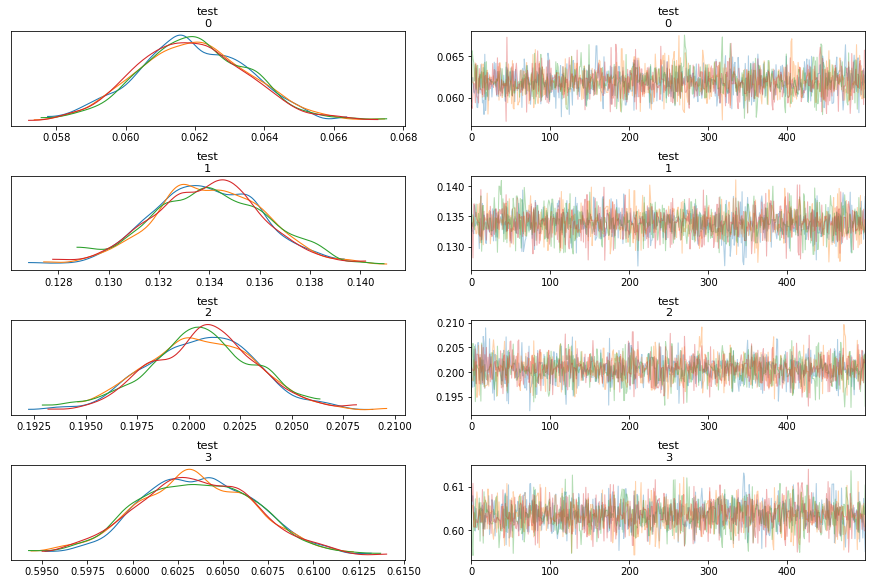

In [338]:
import arviz as az
az.plot_trace(trace)

In [335]:
trace["alpha"][-5:]

KeyError: 'Unknown variable alpha'

In [308]:
likelihoods.dirichletMAP(tensor(test["params"][0][3:]), tensor([30, 100, 0, 0]))

tensor([0.0616, 0.1376, 0.1998, 0.6012], dtype=torch.float64)

In [298]:
testFitLiab55usingPDSpop["params"]

[array([3.76296320e-02, 1.45057598e-09, 9.57079407e-01, 7.82139565e+01,
        4.42296373e+02, 4.99132978e+02, 8.77386719e+02])]

In [268]:
likelihoods.trueVsEst(testFitLiab55usingPDSpop, liabData55, liabParams55[0])

[0.92625964 0.05355783 0.00947096 0.01071157]
est pis: [3.76296320e-02 1.45057598e-09 9.57079407e-01]
tru pis: tensor([0.1000, 0.1000, 0.0500])


Estimate for component: 0
est: P(D|V) [0.92625964 0.05355783 0.00947096 0.01071157] variance: [0.00081718 0.00060646 0.00011224 0.00012678] alphas: [0.92625964 0.05355783 0.00947096 0.01071157]
tru: P(D|V) [0.90008134 0.09169499 0.04462189 0.02842231] alphas: [0.90008134 0.09169499 0.04462189 0.02842231]


Estimate for component: 1
est: P(D|V) [0.91867247 0.00939338 0.05994512 0.01198903] variance: [0.00088665 0.00011043 0.00066874 0.00014057] alphas: [0.91867247 0.00939338 0.05994512 0.01198903]
tru: P(D|V) [0.8898565  0.04471075 0.13626806 0.04590308] alphas: [0.8898565  0.04471075 0.13626806 0.04590308]


Estimate for component: 2
est: P(D|V) [0.87258987 0.05045456 0.05693815 0.02001742] variance: [0.00125394 0.00054035 0.00060563 0.00022125] alphas: [0.87258987 0.05045456 0.05693815 0.02001742]
tru: P(D|V) [0.8742193  0.09155628 0.1359950

([array([0.92625964, 0.05355783, 0.00947096, 0.01071157]),
  array([0.91867247, 0.00939338, 0.05994512, 0.01198903]),
  array([0.87258987, 0.05045456, 0.05693815, 0.02001742])],
 [array([0.00081718, 0.00060646, 0.00011224, 0.00012678]),
  array([0.00088665, 0.00011043, 0.00066874, 0.00014057]),
  array([0.00125394, 0.00054035, 0.00060563, 0.00022125])],
 [array([0.90008134, 0.09169499, 0.04462189, 0.02842231], dtype=float32),
  array([0.8898565 , 0.04471075, 0.13626806, 0.04590308], dtype=float32),
  array([0.8742193 , 0.09155628, 0.13599509, 0.09802781], dtype=float32)])

In [242]:
liabData55["altCounts"][liabData55["affectedGenes"][2]].mean(0)

tensor([18.1799, 15.1418, 15.2744, 43.4923])

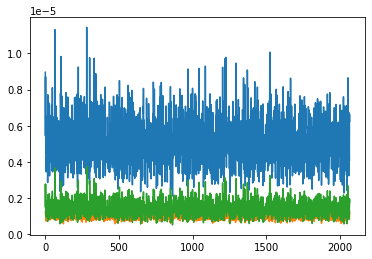

In [154]:
plt.plot(liabData55["afs"][liabData55["affectedGenes"][0]][:, 1:])

In [153]:
likelihoods.trueVsEst(testFitLiab55, liabData55, liabParams55[0])

[0.92357093 0.05582133 0.00944347 0.01116427]
est pis: [0.09690203 0.08913278 0.05712737]
tru pis: tensor([0.1000, 0.1000, 0.0500])


Estimate for component: 0
est: P(D|V) [0.92357093 0.05582133 0.00944347 0.01116427] variance: [7.77361137e-05 5.80428065e-05 1.03016000e-05 1.21576153e-05] alphas: [0.92357093 0.05582133 0.00944347 0.01116427]
tru: P(D|V) [0.92827415 0.05078225 0.01003472 0.01438079] alphas: [0.92827415 0.05078225 0.01003472 0.01438079]


Estimate for component: 1
est: P(D|V) [0.92369846 0.00944477 0.05571398 0.0111428 ] variance: [7.76278293e-05 1.03044299e-05 5.79457551e-05 1.21361706e-05] alphas: [0.92369846 0.00944477 0.05571398 0.0111428 ]
tru: P(D|V) [0.9185538  0.0099292  0.05021581 0.01422138] alphas: [0.9185538  0.0099292  0.05021581 0.01422138]


Estimate for component: 2
est: P(D|V) [0.83209554 0.05029249 0.05018884 0.06742313] variance: [1.38637192e-04 4.73955252e-05 4.73030043e-05 6.23932914e-05] alphas: [0.83209554 0.05029249 0.05018884 0.06742313]
tru: P(D

([array([0.92357093, 0.05582133, 0.00944347, 0.01116427]),
  array([0.92369846, 0.00944477, 0.05571398, 0.0111428 ]),
  array([0.83209554, 0.05029249, 0.05018884, 0.06742313])],
 [array([7.77361137e-05, 5.80428065e-05, 1.03016000e-05, 1.21576153e-05]),
  array([7.76278293e-05, 1.03044299e-05, 5.79457551e-05, 1.21361706e-05]),
  array([1.38637192e-04, 4.73955252e-05, 4.73030043e-05, 6.23932914e-05])],
 [array([0.92827415, 0.05078225, 0.01003472, 0.01438079], dtype=float32),
  array([0.9185538 , 0.0099292 , 0.05021581, 0.01422138], dtype=float32),
  array([0.8293836 , 0.05131904, 0.05137822, 0.068893  ], dtype=float32)])

In [976]:
liabParams55VScale = liabParams23[0]
liabParams55VScale["pDs"] = 
liabParams55VScale["rrMeans"] = tensor([1, 15])
liabParams55VScale["nCtrls"] = tensor([5e4])

liabParams55VScale["pDs"] = pdEmpirical
liabParams55VScale["afMean"] = tensor(1e-4) * pdScale # scale up by sample_prevalence/populaiton_prevalence
liabParams55VScale["meanEffectCovarianceScale"] = tensor(.01)
print("liabParams55VScale", liabParams55VScale)
liabData55VScale = genData.v6liability(**liabParams55VScale)

pdEmpirical = liabParams55VScale["nCases"] / (liabParams55VScale["nCtrls"] + liabParams55VScale["nCases"].sum())
pdScale = pdEmpirical.sum() / liabParams55VScale["pDs"].sum()
print("pdEmpirical", pdEmpirical)
print("pdScale", pdScale)

[autoreload of mvl.genData failed: Traceback (most recent call last):
  File "/Users/alexkotlar/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/Users/alexkotlar/miniconda3/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/Users/alexkotlar/miniconda3/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/Users/alexkotlar/miniconda3/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/Users/alexkotlar/projects/tada/mvl/genData.py", line 698, in <module>
    meanEffectCovarianceScale=tensor(.01), covShared=tensor([ [1, .5], [.5, 

SyntaxError: invalid syntax (<ipython-input-976-21d53c20cd28>, line 2)

In [38]:
liabData55VScale["altCounts"][liabData55VScale["affectedGenes"][1]]

tensor([[6., 3., 3., 0.],
        [5., 2., 2., 0.],
        [3., 1., 3., 1.],
        ...,
        [3., 3., 1., 1.],
        [5., 2., 2., 1.],
        [4., 0., 2., 1.]])

In [394]:
def dirichletMAP(N, alphas):
    n = altCounts.sum(1)


liab55params = testFitLiab55["params"][0]
print("geneCounts", liabData55["altCounts"].shape)
pis = liab55params[0:3]
pis = tensor([1 - pis.sum(), *pis])
alphas = tensor(liab55params[3:])
print("pis", pis)
print("alphas", alphas)
alphasBroadcast = alphas.expand((liabData55["altCounts"].shape[0], len(alphas)))
print('liabData55["altCounts"]', liabData55["altCounts"])
mapEst = Dirichlet(alphas + liabData55["altCounts"]).mean

pd1only = mapEst[:, 1]
pd2only = mapEst[:, 2]
pdboth = mapEst[:, 3]

PD1V = pd1only * pis[1]  + pdboth * pis[3]
PD1V = pd1only * pis[1]  + pdboth * pis[3]
PD1V = pd1only * pis[1]  + pdboth * pis[3]

populationPrevale
# s = mapEst.sample()
print("mapEst mean", mapEst[:, 1].max())
print("prior", Dirichlet(alphas).mean)


# print("posterior MLE", s.mean(1))

# altCounts = tensor(liabData55["altCounts"])

# for geneCounts in liabData55["altCounts"]:
#     # print("geneCounts", geneCounts)
#     ctrls, case1, case2, caseboth = geneCounts
#     # pnotd =


geneCounts torch.Size([20001, 4])
pis tensor([0.7716, 0.0863, 0.0855, 0.0566], dtype=torch.float64)
alphas tensor([ 1360.2433,  7981.6269,  8233.5792, 54585.4850], dtype=torch.float64)
liabData55["altCounts"] tensor([[26.,  0.,  0.,  0.],
        [26.,  0.,  1.,  0.],
        [25.,  0.,  1.,  0.],
        ...,
        [29.,  0.,  0.,  0.],
        [34.,  0.,  0.,  0.],
        [34.,  0.,  0.,  0.]])
mapEst mean tensor(0.1107, dtype=torch.float64)
prior tensor([0.0189, 0.1106, 0.1141, 0.7564], dtype=torch.float64)


In [311]:
liabParams55[0]

{'nGenes': 20000,
 'nCases': tensor([15000., 15000.,  4000.]),
 'nCtrls': tensor(300000.),
 'pDs': tensor([0.0100, 0.0100, 0.0020]),
 'diseaseFractions': tensor([0.1000, 0.1000, 0.0500]),
 'rrShape': tensor(10.),
 'rrMeans': tensor([5., 5.]),
 'afShape': tensor(50.),
 'afMean': tensor(1.0000e-04),
 'covShared': tensor([[0.0100, 0.0050],
         [0.0050, 0.0100]]),
 'covSingle': tensor([[0.0100, 0.0000],
         [0.0000, 0.0100]]),
 'rrtype': 'default'}

In [314]:
likelihoods.trueVsEst(testFitLiab55, liabData55, liabParams55[0])

[0.92402448 0.05543952 0.0094481  0.0110879 ]
est pis: [0.08626347 0.0855069  0.05663966]
tru pis: tensor([0.1000, 0.1000, 0.0500])


Estimate for component: 0
est: P(D|V) [0.92402448 0.05543952 0.0094481  0.0110879 ] variance: [4.87285678e-05 3.63475947e-05 6.49603449e-06 7.61085799e-06] alphas: [0.92402448 0.05543952 0.0094481  0.0110879 ]
tru: P(D|V) [0.9180214  0.05042387 0.00992662 0.01429007] alphas: [0.9180214  0.05042387 0.00992662 0.01429007]


Estimate for component: 1
est: P(D|V) [0.92208805 0.0094283  0.0570697  0.01141394] variance: [4.97613859e-05 6.46897504e-06 3.72735891e-05 7.81566849e-06] alphas: [0.92208805 0.0094283  0.0570697  0.01141394]
tru: P(D|V) [0.9199299  0.00995083 0.0507883  0.01441492] alphas: [0.9199299  0.00995083 0.0507883  0.01441492]


Estimate for component: 2
est: P(D|V) [0.83059685 0.04983406 0.05140714 0.06816195] variance: [8.77961596e-05 2.95453712e-05 3.04275571e-05 3.96320200e-05] alphas: [0.83059685 0.04983406 0.05140714 0.06816195]
tru: P(D

([array([0.92402448, 0.05543952, 0.0094481 , 0.0110879 ]),
  array([0.92208805, 0.0094283 , 0.0570697 , 0.01141394]),
  array([0.83059685, 0.04983406, 0.05140714, 0.06816195])],
 [array([4.87285678e-05, 3.63475947e-05, 6.49603449e-06, 7.61085799e-06]),
  array([4.97613859e-05, 6.46897504e-06, 3.72735891e-05, 7.81566849e-06]),
  array([8.77961596e-05, 2.95453712e-05, 3.04275571e-05, 3.96320200e-05])],
 [array([0.9180214 , 0.05042387, 0.00992662, 0.01429007], dtype=float32),
  array([0.9199299 , 0.00995083, 0.0507883 , 0.01441492], dtype=float32),
  array([0.82631224, 0.05016553, 0.05111575, 0.06759135], dtype=float32)])

In [296]:
print(liabData23["afs"][liabData23["unaffectedGenes"]].mean(0), liabData23["afs"][liabData23["unaffectedGenes"]].std(0))
print(liabData23["afs"][liabData23["affectedGenes"][0]].mean(0), liabData23["afs"][liabData23["affectedGenes"][0]].std(0))
print(liabData23["afs"][liabData23["affectedGenes"][1]].mean(0), liabData23["afs"][liabData23["affectedGenes"][1]].std(0))
print(liabData23["afs"][liabData23["affectedGenes"][2]].mean(0), liabData23["afs"][liabData23["affectedGenes"][2]].std(0))

tensor([8.9832e-05, 4.4916e-06, 4.4916e-06, 1.1978e-06]) tensor([1.2782e-05, 6.3908e-07, 6.3908e-07, 1.7042e-07])
tensor([8.3564e-05, 9.1170e-06, 4.4954e-06, 2.9224e-06]) tensor([1.1682e-05, 2.0791e-06, 6.1217e-07, 7.9063e-07])
tensor([7.7074e-05, 4.4986e-06, 1.3685e-05, 4.9111e-06]) tensor([1.1335e-05, 6.3457e-07, 2.9536e-06, 1.2501e-06])
tensor([6.7820e-05, 9.0539e-06, 1.3576e-05, 9.7546e-06]) tensor([1.1747e-05, 2.1626e-06, 2.9663e-06, 3.4168e-06])


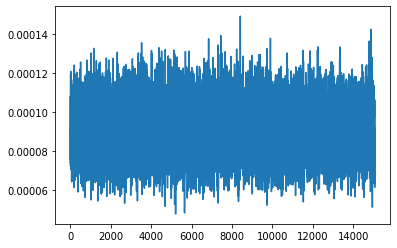

In [297]:
plt.plot(liabData23["afs"][liabData23["unaffectedGenes"]][:, 0])

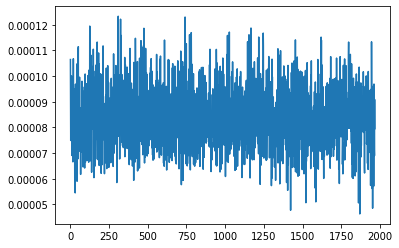

In [298]:
plt.plot(liabData23["afs"][liabData23["affectedGenes"][0]][:, 0])

In [592]:
testFitLiab23 = likelihoods.fitFnBivariate(liabData23["altCounts"], liabParams[0]["pDs"], nEpochs=1)

NameError: name 'liabParams' is not defined

In [591]:
testFitLiab23 = likelihoods.fitFnBivariate(liabData23["altCounts"], liabParams[0]["pDs"], nEpochs=1)

NameError: name 'liabParams' is not defined

In [301]:
testFitLiab23["params"]

[array([9.52747006e-02, 7.11965781e-02, 6.47829114e-02, 1.35842372e+03,
        3.32494714e+03, 5.41889133e+03, 1.43262698e+04])]

In [273]:
print(liabData["afs"][liabData["unaffectedGenes"]].mean(0), liabData["afs"][liabData["unaffectedGenes"]].std(0))
print(liabData["cata["afs"][liabData["affectedGenes"][0]].std(0))
print(liabData["afs"][liabData["affectedGenes"][1]].mean(0), liabData["afs"][liabData["affectedGenes"][1]].std(0))
print(liabData["afs"][liabData["affectedGenes"][1]].mean(0), liabData["afs"][liabData["affectedGenes"][1]].std(0))

tensor([9.0031e-05, 4.5015e-06, 4.5015e-06, 1.2004e-06]) tensor([1.2711e-05, 6.3556e-07, 6.3556e-07, 1.6948e-07])
tensor([8.5017e-05, 7.8241e-06, 4.4815e-06, 2.4652e-06]) tensor([1.2880e-05, 3.3637e-06, 6.3073e-07, 1.3876e-06])
tensor([8.5010e-05, 4.4760e-06, 7.7436e-06, 2.4350e-06]) tensor([1.2961e-05, 6.4265e-07, 3.4145e-06, 1.4108e-06])
tensor([8.5010e-05, 4.4760e-06, 7.7436e-06, 2.4350e-06]) tensor([1.2961e-05, 6.4265e-07, 3.4145e-06, 1.4108e-06])


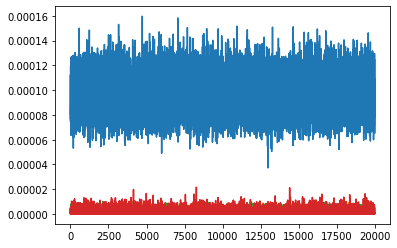

In [351]:
plt.plot(liabData55["afs"][:, 0:])

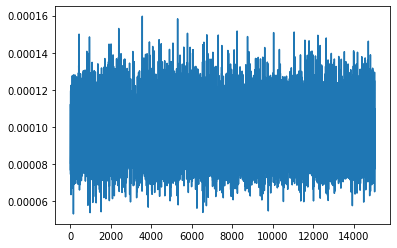

In [326]:
plt.plot(liabData55["afs"][liabData55["unaffectedGenes"]][:, 0])

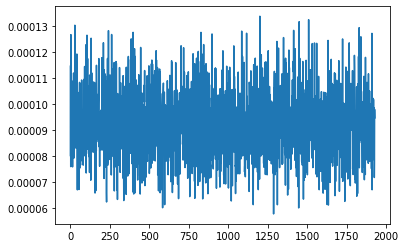

In [333]:
plt.plot(liabData55["afs"][liabData55["affectedGenes"][0]][:, 0])

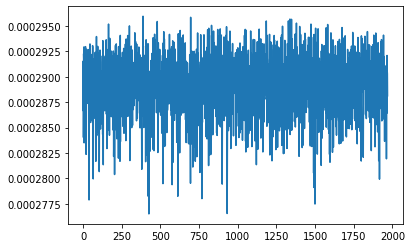

In [1416]:
plt.plot(liabData55cov["afs"][liabData55cov["affectedGenes"][0]][:, 0])

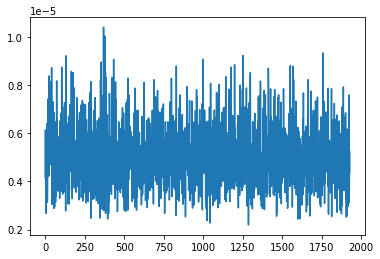

In [334]:
plt.plot(liabData55["afs"][liabData55["affectedGenes"][0]][:, 1])

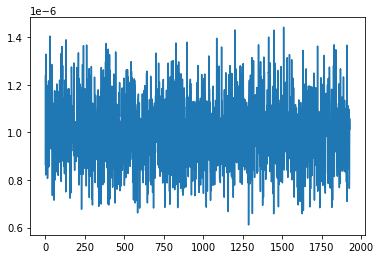

In [335]:
plt.plot(liabData55["afs"][liabData55["affectedGenes"][0]][:, 2])

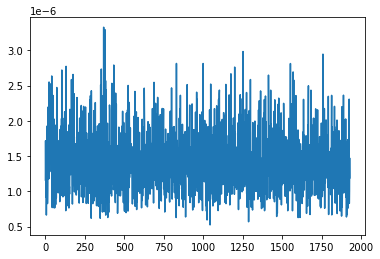

In [337]:
plt.plot(liabData55["afs"][liabData55["affectedGenes"][0]][:, 3])

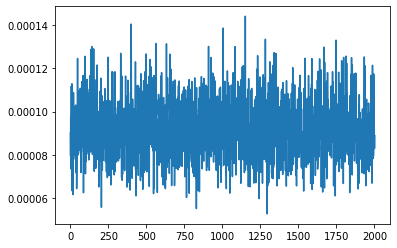

In [338]:
plt.plot(liabData55["afs"][liabData55["affectedGenes"][1]][:, 0])

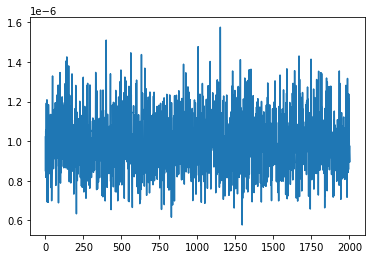

In [339]:
plt.plot(liabData55["afs"][liabData55["affectedGenes"][1]][:, 1])

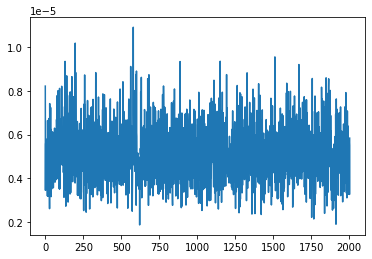

In [340]:
plt.plot(liabData55["afs"][liabData55["affectedGenes"][1]][:, 2])

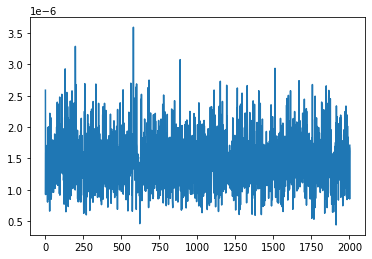

In [341]:
plt.plot(liabData55["afs"][liabData55["affectedGenes"][1]][:, 3])

In [266]:
likelihoods.trueVsEst(testFitLiabNull, liabData, liabParams[0])

[0.79253877 0.13250075 0.03962694 0.03533353]
est pis: [0.04190918 0.03436422 0.01496829]
tru pis: tensor([0.1000, 0.1000, 0.0500])


Estimate for component: 0
est: P(D|V) [0.79253877 0.13250075 0.03962694 0.03533353] variance: [4.01727641e-05 2.80841775e-05 9.29832564e-06 8.32795783e-06] alphas: [0.79253877 0.13250075 0.03962694 0.03533353]
tru: P(D|V) [0.85016525 0.07824123 0.04481465 0.02465191] alphas: [0.85016525 0.07824123 0.04481465 0.02465191]


Estimate for component: 1
est: P(D|V) [0.78788613 0.03939431 0.13635755 0.03636201] variance: [4.05929237e-05 9.19171269e-06 2.86042770e-05 8.51098132e-06] alphas: [0.78788613 0.03939431 0.13635755 0.03636201]
tru: P(D|V) [0.8501009  0.04475955 0.07743556 0.02434993] alphas: [0.8501009  0.04475955 0.07743556 0.02434993]


Estimate for component: 2
est: P(D|V) [0.65103787 0.1088439  0.11267355 0.12744469] variance: [4.55998573e-05 1.94686932e-05 2.00670869e-05 2.23199713e-05] alphas: [0.65103787 0.1088439  0.11267355 0.12744469]
tru: P(D

([array([0.79253877, 0.13250075, 0.03962694, 0.03533353]),
  array([0.78788613, 0.03939431, 0.13635755, 0.03636201]),
  array([0.65103787, 0.1088439 , 0.11267355, 0.12744469])],
 [array([4.01727641e-05, 2.80841775e-05, 9.29832564e-06, 8.32795783e-06]),
  array([4.05929237e-05, 9.19171269e-06, 2.86042770e-05, 8.51098132e-06]),
  array([4.55998573e-05, 1.94686932e-05, 2.00670869e-05, 2.23199713e-05])],
 [array([0.85016525, 0.07824123, 0.04481465, 0.02465191], dtype=float32),
  array([0.8501009 , 0.04475955, 0.07743556, 0.02434993], dtype=float32),
  array([0.77417886, 0.08262555, 0.08446138, 0.05520059], dtype=float32)])

In [263]:
testFitLiabNull["params"]

[array([4.19091769e-02, 3.43642197e-02, 1.49682910e-02, 3.61048333e+03,
        1.20723875e+04, 1.24971520e+04, 5.30080809e+04])]

In [ ]:
likelihoods.empiricalPDGivenV()

In [254]:
liabData["affectedGenes"]

076,
  5079,
  5085,
  5088,
  5098,
  5103,
  5112,
  5122,
  5124,
  5129,
  5133,
  5140,
  5143,
  5161,
  5162,
  5163,
  5183,
  5198,
  5205,
  5231,
  5238,
  5250,
  5254,
  5257,
  5263,
  5269,
  5282,
  5292,
  5316,
  5318,
  5323,
  5337,
  5338,
  5343,
  5357,
  5362,
  5364,
  5382,
  5388,
  5389,
  5401,
  5404,
  5418,
  5434,
  5463,
  5485,
  5486,
  5489,
  5492,
  5496,
  5501,
  5503,
  5506,
  5517,
  5522,
  5551,
  5563,
  5580,
  5582,
  5590,
  5591,
  5592,
  5606,
  5610,
  5619,
  5624,
  5625,
  5634,
  5647,
  5692,
  5698,
  5710,
  5712,
  5713,
  5714,
  5719,
  5722,
  5727,
  5749,
  5758,
  5762,
  5782,
  5783,
  5786,
  5790,
  5791,
  5796,
  5802,
  5818,
  5841,
  5850,
  5871,
  5887,
  5890,
  5891,
  5893,
  5909,
  5910,
  5923,
  5932,
  5939,
  5942,
  5962,
  5967,
  5976,
  5986,
  5987,
  6006,
  6013,
  6032,
  6034,
  6039,
  6052,
  6057,
  6095,
  6122,
  6130,
  6131,
  6132,
  6134,
  6158,
  6161,
  6164,
  6166,
  6167,
  6

In [58]:
import matplotlib.pyplot as plt
# print(liabData["affectedGenes"])
# print(liabData["afs"][liabData["affectedGenes"][0]])
print(liabData["afs"][liabData["unaffectedGenes"]].mean(0) / liabData["afs"][liabData["unaffectedGenes"][0]].mean(0))
plt.plot(liabData["afs"][liabData["affectedGenes"][2]])

NameError: name 'liabData' is not defined

In [590]:
testFitLiab = likelihoods.fitFnBivariate(liabData["altCounts"], liabParams["pDs"], nEpochs=1)

NameError: name 'liabData' is not defined

In [224]:
testFitLiab["params"]

NameError: name 'testFitLiab' is not defined

In [82]:
rrParams = {"nCases":tensor([15e4, 15e4, 4e3]), "nCtrls": tensor(5e4), "pDs": tensor([.01, .01, .002]), "diseaseFractions": tensor([.05, .05, .01]), "rrMeans": tensor([10, 10, 2]), "afMean": tensor(1e-4)}

rrData = genData.v6normal(**rrParams)
rrData["afs"].mean(0)

TESTING v6normal WITH: nCases tensor([150000., 150000.,   4000.]) nCtrls tensor(50000.) rrMeans tensor([10, 10,  2]) afMean tensor(1.0000e-04) afShape tensor(50.) diseaseFractions tensor([0.0500, 0.0500, 0.0100]) pDs tensor([0.0100, 0.0100, 0.0020]) covShared tensor([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]) covSingle tensor([[1, 0],
        [0, 1]])
covSharedStr c(1,0,0,0,1,0,0,0,1)
covSingleStr c(1,0,0,1)
sharedMeans c(12, 12, 22)
singleMeans c(10, 10)
len covshared 3
r.get('rrsOne') [[10.05245018 10.62891095]
 [10.43362414 10.29744204]
 [ 8.70377596  9.01312114]
 ...
 [11.0497133  11.04957763]
 [11.70848645 10.11697609]
 [ 8.1544438  10.30868597]]
rrsShared tensor([[10.9237, 12.9271, 22.0495],
        [12.6921, 12.6409, 21.5572],
        [11.4332, 12.5551, 21.0825],
        ...,
        [13.2905, 12.0015, 21.9513],
        [12.0812, 12.4475, 24.3556],
        [11.6018, 12.5093, 21.6385]], dtype=torch.float64)
rrsOne tensor([[10.0525, 10.6289],
        [10.4336, 10.2974],
   

tensor([9.6245e-05, 1.6038e-06, 1.5611e-06, 4.3094e-07], dtype=torch.float64)

In [83]:
rrData["altCounts"].mean(0)

tensor([33.5964,  0.5560,  0.5404,  0.1530], dtype=torch.float64)

In [84]:
print(rrData["afs"][rrData["unaffectedGenes"]].mean(0), rrData["afs"][rrData["unaffectedGenes"]].std(0))
print(rrData["afs"][rrData["affectedGenes"][0]].mean(0), rrData["afs"][rrData["affectedGenes"][0]].std(0))
print(rrData["afs"][rrData["affectedGenes"][1]].mean(0), rrData["afs"][rrData["affectedGenes"][1]].std(0))
print(rrData["afs"][rrData["affectedGenes"][2]].mean(0), rrData["afs"][rrData["affectedGenes"][2]].std(0))

tensor([9.7689e-05, 9.9887e-07, 9.9887e-07, 1.9977e-07], dtype=torch.float64) tensor([1.3834e-05, 1.4145e-07, 1.4145e-07, 2.8290e-08], dtype=torch.float64)
tensor([8.6192e-05, 9.9408e-06, 9.9112e-07, 1.9882e-06], dtype=torch.float64) tensor([1.2615e-05, 1.7908e-06, 1.4448e-07, 3.5816e-07], dtype=torch.float64)
tensor([8.6884e-05, 9.9880e-07, 9.9971e-06, 1.9994e-06], dtype=torch.float64) tensor([1.1897e-05, 1.3606e-07, 1.7023e-06, 3.4046e-07], dtype=torch.float64)
tensor([7.1430e-05, 1.1984e-05, 1.1754e-05, 4.3382e-06], dtype=torch.float64) tensor([9.9220e-06, 1.9636e-06, 1.8891e-06, 6.2026e-07], dtype=torch.float64)


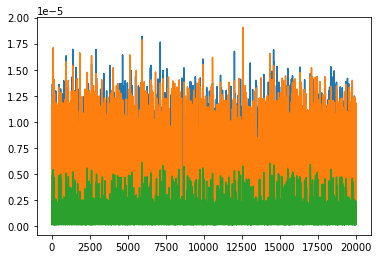

In [87]:
plt.plot(rrData["afs"][:,1:])

In [278]:
print(rrData["afs"][rrData["unaffectedGenes"]].mean(0), rrData["afs"][rrData["unaffectedGenes"]].std(0))
print(rrData["afs"][rrData["affectedGenes"][0]].mean(0), rrData["afs"][rrData["affectedGenes"][0]].std(0))
print(rrData["afs"][rrData["affectedGenes"][1]].mean(0), rrData["afs"][rrData["affectedGenes"][1]].std(0))
print(rrData["afs"][rrData["affectedGenes"][2]].mean(0), rrData["afs"][rrData["affectedGenes"][2]].std(0))

tensor([9.7743e-05, 9.9941e-07, 9.9941e-07, 1.9988e-07], dtype=torch.float64) tensor([1.3880e-05, 1.4192e-07, 1.4192e-07, 2.8385e-08], dtype=torch.float64)
tensor([9.6122e-05, 2.2908e-06, 9.9869e-07, 4.5816e-07], dtype=torch.float64) tensor([1.4118e-05, 8.4819e-07, 1.4567e-07, 1.6964e-07], dtype=torch.float64)
tensor([9.6739e-05, 1.0050e-06, 2.2970e-06, 4.5940e-07], dtype=torch.float64) tensor([1.3382e-05, 1.3917e-07, 8.9192e-07, 1.7838e-07], dtype=torch.float64)
tensor([9.1717e-05, 4.1755e-06, 4.0264e-06, 1.2177e-06], dtype=torch.float64) tensor([1.3777e-05, 1.0895e-06, 1.2189e-06, 2.7454e-07], dtype=torch.float64)


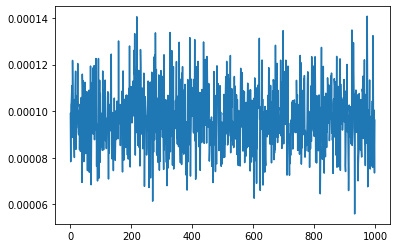

In [343]:
plt.plot(rrData["afs"][rrData["affectedGenes"][1]][:, 0])

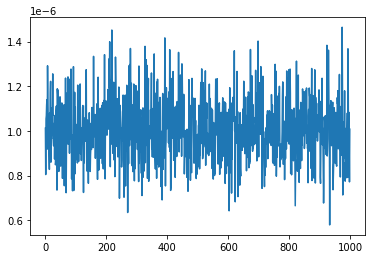

In [344]:
plt.plot(rrData["afs"][rrData["affectedGenes"][1]][:, 1])

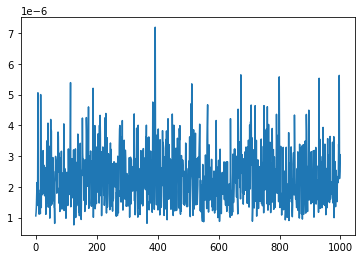

In [345]:
plt.plot(rrData["afs"][rrData["affectedGenes"][1]][:, 2])

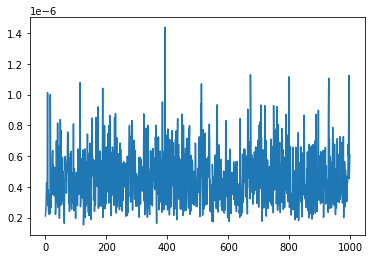

In [346]:
plt.plot(rrData["afs"][rrData["affectedGenes"][1]][:, 3])

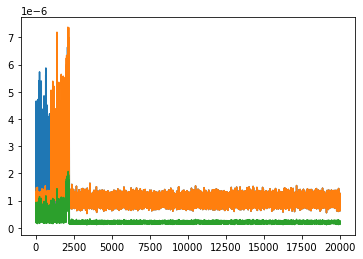

In [348]:
plt.plot(rrData["afs"][:,1:])

In [88]:
testFitRRData = likelihoods.fitFnBivariate(rrData["altCounts"], rrParams["pDs"], nEpochs=1)

torch.Size([20000, 4])
nGenes
n tensor([26., 42., 26.,  ..., 38., 25., 30.], dtype=torch.float64)
pdsall tensor([0.9780, 0.0100, 0.0100, 0.0020])
pDS are tensor([0.9780, 0.0100, 0.0100, 0.0020])
altCounts are tensor([[25.,  0.,  1.,  0.],
        [42.,  0.,  0.,  0.],
        [26.,  0.,  0.,  0.],
        ...,
        [37.,  0.,  1.,  0.],
        [25.,  0.,  0.,  0.],
        [29.,  0.,  0.,  1.]], dtype=torch.float64)
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9d915ea9e0>
Running single-step optimization
{'method': 'Nelder-Mead', 'options': {'maxiter': 20000, 'adaptive': True}}
Epoch took 116.36692976951599


In [89]:
testFitRRData["params"]

[array([4.88589192e-02, 4.40487015e-02, 1.46347276e-02, 3.77860056e+06,
        4.56102729e+07, 4.66102139e+07, 9.52474881e+07])]

In [223]:
likelihoods.trueVsEst(testFitRRData, rrData, rrParams)

[0.86331077 0.1065516  0.00882731 0.02131032]
est pis: [0.04885892 0.0440487  0.01463473]
tru pis: tensor([0.0500, 0.0500, 0.0100])


Estimate for component: 0
est: P(D|V) [0.86331077 0.1065516  0.00882731 0.02131032] variance: [2.75675827e-08 2.22395852e-08 2.04397157e-09 4.87228004e-09] alphas: [0.86331077 0.1065516  0.00882731 0.02131032]
tru: P(D|V) [0.86192199 0.09940754 0.00991122 0.01988151] alphas: [0.86192199 0.09940754 0.00991122 0.01988151]


Estimate for component: 1
est: P(D|V) [0.86089751 0.00880263 0.10858322 0.02171664] variance: [2.78976668e-08 2.03261088e-09 2.25488826e-08 4.94924449e-09] alphas: [0.86089751 0.00880263 0.10858322 0.02171664]
tru: P(D|V) [0.868842   0.00998795 0.09997096 0.01999419] alphas: [0.868842   0.00998795 0.09997096 0.01999419]


Estimate for component: 2
est: P(D|V) [0.76858148 0.09485992 0.09693959 0.03961901] variance: [3.69920174e-08 1.78574127e-08 1.82069822e-08 7.91347399e-09] alphas: [0.76858148 0.09485992 0.09693959 0.03961901]
tru: P(D

([array([0.86331077, 0.1065516 , 0.00882731, 0.02131032]),
  array([0.86089751, 0.00880263, 0.10858322, 0.02171664]),
  array([0.76858148, 0.09485992, 0.09693959, 0.03961901])],
 [array([2.75675827e-08, 2.22395852e-08, 2.04397157e-09, 4.87228004e-09]),
  array([2.78976668e-08, 2.03261088e-09, 2.25488826e-08, 4.94924449e-09]),
  array([3.69920174e-08, 1.78574127e-08, 1.82069822e-08, 7.91347399e-09])],
 [array([0.86192199, 0.09940754, 0.00991122, 0.01988151]),
  array([0.868842  , 0.00998795, 0.09997096, 0.01999419]),
  array([0.71429575, 0.11983877, 0.11753917, 0.04338192])])

0.0009990209594597295

ValueError: pVgivenNotD: invalid params: pD: 0.05000000074505806, pV: 1.9999999494757503e-05, pVgivenD: 0.0009990209946408868, (pD*pVgivenD).sum(): 4.995104973204434e-05 yield: p = -3.1527422834187746e-05

In [222]:
rr = tensor(50)
pd_pop = tensor(.01)
pd_sample = tensor(.05)
af_pop = tensor(1e-4)
pdscale = pd_pop / pd_sample
af_scaled = af_pop * 1/pdscale
print('af_pop', af_pop)
print('af_scaled', af_scaled)
print("pdscale", pdscale)
pvd_scaled = likelihoods.pVgivenDapprox(rr, af_scaled)
pvd_pop = likelihoods.pVgivenDapprox(rr, af_pop)
print("pvd pop", pvd_pop)
print("pvd scaled", pvd_scaled)
print("af_pop / pvd_pop", af_pop / pvd_pop)
print("af_scaled / pvd_scaled", af_scaled / pvd_scaled)
print('pd_sample * 1/pdscale', pd_sample * pdscale)
likelihoods.pVgivenNotD(pd_sample, af_scaled, pvd_scaled)

af_pop tensor(1.0000e-04)
af_scaled tensor(0.0005)
pdscale tensor(0.2000)
pvd pop tensor(0.0050)
pvd scaled tensor(0.0250)
af_pop / pvd_pop tensor(0.0200)
af_scaled / pvd_scaled tensor(0.0200)
pd_sample * 1/pdscale tensor(0.0100)


ValueError: pVgivenNotD: invalid params: pD: 0.05000000074505806, pV: 0.0005000000237487257, pVgivenD: 0.02500000037252903, (pD*pVgivenD).sum(): 0.0012500000884756446 yield: p = -0.0007894737645983696

In [134]:
# So if you have high prevalence, you can have large penetrance alleles only with relatively large allele frequencies
# for rr = 50, it's 1e-3 minimum for a total prevalence of .05

pvd = likelihoods.pVgivenD(tensor(50), tensor(1e-4))
likelihoods.pVgivenNotD(tensor(.05), tensor(1e-3), pvd)

tensor(0.0008)

In [ ]:
# What is the relationship between sample prevalence and population prevalence?

# There is an actual P(!D)
# That is again mapped to sample prevalence

# but P(!D) = 1 - Sum_{P(D)} only if we've enumerated all possible P(D's) 

In [162]:
# Say P(V|D) is .002 to .004
pDs = tensor([.01, .01, .002])
rrs = tensor([20, 20, 40])
afMean = tensor(1e-4)
pvd = likelihoods.pVgivenD(rrs, afMean)
pvd #.002, .002, .004
pvd * .05
# My P(!Dsample) is constrained by the simplex 1 - pDsSample.sum()
# but, the population P(!D) is not necessarily (1 - pDs.sum()) because there may be more pDs that I am not including in the study

# So I need to calculated my P(V|!D) using the population estimate

# What is the marginal allele count with a total of 1000
# It may be P(V|D) * PDsample


tensor([9.9810e-05, 9.9810e-05, 1.9922e-04])

In [163]:
pvd * .05 * 5e4


tensor([4.9905, 4.9905, 9.9612])

import tensorflow as tf

In [278]:
pytorch_tensor = torch.zeros(10)
np_tensor = pytorch_tensor.numpy()
tf_tensor = tf.convert_to_tensor(np_tensor)
tf_tensor

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

In [281]:
tf_tensor = tf.convert_to_tensor(rrData["altCounts"].numpy())

In [283]:
tf_tensor.shape

TensorShape([20000, 4])

In [576]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "torch"])

from torch import tensor, Tensor
from pyro.distributions import DirichletMultinomial
import torch

# https://discuss.pytorch.org/t/computing-the-hessian-matrix-correctness-and-performance/53624
def compute_hessian(grads, params):
    H = []
    for i, (grad, p) in enumerate(zip(grads, params)):
        grad = grad.reshape(-1)
        d = len(grad)
        dg = torch.zeros((d, d))

        for j, g in enumerate(grad):
            g2 = autograd.grad(g, p, create_graph=True)[0].view(-1)
            dg[j] = g2

        H.append(dg)

    return H

# based on MGLM
def dgdirmn(Y, alpha, beta): 
    assert beta.shape == alpha.shape

    assert alpha.shape[0] == Y.shape[1] - 1
    alpha = alpha.expand((Y.shape[0], alpha.shape[0]))#     d <- ncol(Y)
    beta = beta.expand((Y.shape[0], beta.shape[0]))#     d <- ncol(Y)

    m = Y.sum(1) #m
    Yrev = Y.T.flip(0) 
    YrevCumsum = Yrev.cumsum(0) 
    z = YrevCumsum.flip(0).T

    n1 = torch.lgamma(m + 1)
    n2 = (torch.lgamma(Y[:, :-1] + alpha)).sum(1)
    n3 = (torch.lgamma(z[:, 1:] + beta)).sum(1)
    n4 = (torch.lgamma(alpha + beta)).sum(1)

    numerator = n1 + n2 + n3 + n4
    
    d1 = torch.lgamma(Y + 1).sum(1)
    d2 = torch.lgamma(alpha).sum(1)
    d3 = torch.lgamma(beta).sum(1)
    d4 = torch.lgamma(alpha + beta + z[:, :-1]).sum(1)

    denominator = d1 + d2 + d3 + d4

    return numerator - denominator

Y = tensor([
    [0, 1, 19],
    [9, 11, 0],
    [0, 0, 20],
    [1, 19, 0],
    [0, 16, 4],
    [2, 14, 4],
    [1, 2, 17],
    [19, 1, 0],
    [2, 16, 2],
    [0, 20, 0]
]).type(torch.float32)

# alpha = tensor([0.2, 0.5]).requires_grad_(True)
# beta = tensor([0.7, 0.4]).requires_grad_(True)

# loss = -dgdirmn(Y, alpha, beta)

# loss.sum().backward()
# print(alpha.grad)
# print(beta.grad)

# print(compute_hessian(alpha.grad, alpha))

##============================================================## 
## Generate GDM data 
##============================================================##
#' @rdname gdirmn 
#' 
#' @param n the number of random vectors to generate.  When \code{size} is a scalar and \code{alpha} is a vector, 
#' must specify \code{n}.  When \code{size} is a vector and \code{alpha} is a matrix, \code{n} is optional.
#' The default value of \code{n} is the length of \code{size}. If given, \code{n} should be equal to 
#' the length of \code{size}.
#' @param size a number or vector specifying the total number of objects that are put
#' into d categories in the generalized Dirichlet multinomial distribution.
#' 
#' @export rgdirmn 
# rgdirmn <- function(n, size, alpha, beta) {
    
#     if (length(alpha) != length(beta)) 
#         stop("The size of alpha and beta should match.")
    
#     if (is.vector(alpha) && missing(n)) 
#         stop("When alpha and beta are vectors, must give n.")
    
#     if (is.vector(alpha)) {
#         alpha <- t(matrix(alpha, length(alpha), n))
#         beta <- t(matrix(beta, length(beta), n))
#         if (length(size) == 1) {
#             size <- rep(size, n)
#         } else {
#             stop("The length of size variable doesn't match with alpha or beta")
#         }
#     } else {
#         if (missing(n)) {
#             n <- dim(alpha)[1]
#         } else if (length(n) != 1) {
#             stop("n should be a scalar.")
#         } else if (n != dim(alpha)[1]) 
#             stop("The sizes of the input alpha don't match with n")
#     }
    
#     k <- dim(alpha)[2]
#     if (k < 1) {
#         stop("The multivariate response data need to have more than one category.")
#     }
    
#     if (!is.vector(size)) {
#         stop("n must be a scalar, or a column vector matches with \n\t\t\tthe number of rows of alpha")
#     } else if (length(size) != n) 
#         stop("The length of size should match with n")
    
#     ##----------------------------------------## 
#     ## Generate data
#     ##----------------------------------------## 
    
#     rdm <- matrix(0, n, (k + 1))
#     rdm[, 1] = size
    
#     for (i in 1:k) {
#         rdm[, c(i, i + 1)] <- rdirmn(size = rdm[, i], alpha = cbind(alpha[, i], beta[, 
#             i]), n)
#     }
    
#     return(rdm)
# }
# size is the marginal count
def rgdirmn(size: Tensor, alphas: Tensor, betas: Tensor):
    assert len(alphas.shape) > 0 and len(betas.shape) > 0 #is list
    assert alphas.shape == betas.shape

    # number of random vectors to generate
    n = alphas.shape[0]
    k = alphas.shape[1]
    # print("k", k)
    # print("n", n)
    assert k >= 1
    
    assert size.shape[0] == n    
    res = torch.zeros(n, k)
    res[:, 0] = size[0]
    # print("res", res)
    # print("res", res)
    # count_col = n.expand(n, 2)
    concentrations = torch.stack((tensor(test_alphas), tensor(test_betas))).T
    for k_idx in range(0, k - 1):
        # if torch supported inhomogenous total_count, this would work:
        #dm = DirichletMultinomial(concentration = concentration, total_count = res[:, i], validate_args=False)
        for n_idx in range(n):
            concentration = concentrations[k_idx, n_idx]
            # print(f"at k=={k_idx}, n_idx={n_idx}, concentration={concentration}")
            if res[n_idx, k_idx] == 0:
                res[n_idx, k_idx:k_idx+2] = tensor([0., 0.])
            else:
                dm = DirichletMultinomial(concentration = concentration, total_count = res[n_idx, k_idx])
                sample = dm.sample()
                res[n_idx, k_idx:k_idx+2] = sample

                # print("sample", sample)
                # print("sample", sample)
                # print("res[:, i:i+1]", res[:, i:i+2])
    
    return res

In [502]:
size = tensor([10., 20, 50, 100])
alphas = tensor([ [1.,2,3], [4,5,6], [4,5,6], [4,5,6] ])
betas = tensor([ [7,8.,9], [10,11,12], [10,11,12], [10,11,12] ])
rgdirmn(size, alphas, betas)

s, i 0 0
s, i 1 0
s, i 2 0
s, i 3 0
s, i 0 1
s, i 1 1
s, i 2 1
s, i 3 1


tensor([[5., 0., 5.],
        [1., 5., 4.],
        [3., 3., 4.],
        [3., 2., 5.]])

In [493]:
test_alphas = np.genfromtxt("/Users/alexkotlar/test_alphas.csv", delimiter = ",")
test_betas = np.genfromtxt("/Users/alexkotlar/test_betas.csv", delimiter = ",")
test_size = np.genfromtxt("/Users/alexkotlar/test_size.csv", delimiter = ",")

In [520]:
test_size

array([6., 5., 5., 3., 3., 3., 2., 6., 6., 7.])

In [562]:
test_alphas

array([[0.50219235, 0.08988614, 0.43808998, 0.09111356],
       [0.13153117, 0.09627446, 0.76406062, 1.75737562],
       [0.07891709, 0.20163395, 0.26196129, 0.13792961],
       [0.88678481, 0.7398405 , 0.7734046 , 0.1111935 ],
       [0.11697127, 0.1233795 , 0.81437912, 0.69001432],
       [0.31863009, 0.02931671, 0.43845057, 0.22179423],
       [0.58179068, 0.38885425, 0.72022155, 0.18290768],
       [0.71453271, 0.51085626, 0.23094453, 0.41732329],
       [0.82525943, 0.91381419, 1.15772946, 1.06540233],
       [0.35986213, 2.31029682, 0.24707599, 0.97020202]])

In [563]:
test_betas

array([[0.10162924, 0.44706218, 0.26199577, 0.44890327],
       [1.40320349, 1.73859795, 0.06884403, 1.06435567],
       [1.77677563, 0.17886485, 0.37888356, 1.16241932],
       [0.62286739, 1.8974657 , 2.58195893, 1.64852175],
       [0.52228335, 2.27192549, 0.12983414, 2.06209602],
       [1.32223096, 0.98046414, 0.71302498, 0.01274972],
       [0.36344033, 1.39882562, 0.63799424, 1.08752835],
       [1.31906574, 1.82487242, 0.20169159, 0.27053949],
       [0.04377907, 1.38129873, 0.06991695, 1.00845187],
       [1.87865588, 0.83885188, 0.09248988, 2.07440475]])

In [570]:
torch.stack((tensor(test_alphas), tensor(test_betas))).T[3, 9]

tensor([0.9702, 2.0744], dtype=torch.float64)

In [580]:
import random
random.seed(a=100)
rgdirmn(tensor(test_size), tensor(test_alphas), tensor(test_betas))

tensor([[3., 0., 3., 0.],
        [0., 0., 6., 0.],
        [0., 6., 0., 0.],
        [3., 0., 0., 3.],
        [1., 0., 4., 1.],
        [1., 0., 0., 5.],
        [0., 3., 3., 0.],
        [3., 2., 0., 1.],
        [5., 0., 1., 0.],
        [0., 4., 2., 0.]])

In [535]:

print("alphas", alphas)
print("betas", betas)

alphas tensor([[1., 2., 3.],
        [4., 5., 6.],
        [4., 5., 6.],
        [4., 5., 6.]])
betas tensor([[ 7.,  8.,  9.],
        [10., 11., 12.],
        [10., 11., 12.],
        [10., 11., 12.]])


In [589]:
import tensorflow_probability as tfp
tfd = tfp.distributions
s = tfd.Multinomial(total_count=[30, 10, 20], probs=[[0.1, 0.9], [0.5, 0.5], [0.2, 0.8]])
s.sample()

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[ 1., 29.],
       [ 8.,  2.],
       [ 2., 18.]], dtype=float32)>

In [586]:
alphas[:, 0]

tensor([1., 4., 4., 4.])

In [385]:
alphas.shape

torch.Size([2, 3])

In [386]:
betas.shape

torch.Size([2, 3])

In [415]:
torch.cat((alphas, betas),1).T

tensor([[ 1,  4],
        [ 2,  5],
        [ 3,  6],
        [ 7, 10],
        [ 8, 11],
        [ 9, 12]])

In [426]:
torch.cat((alphas, betas), 1)

tensor([[ 1,  2,  3,  7,  8,  9],
        [ 4,  5,  6, 10, 11, 12]])

In [420]:
betas.T

tensor([[ 7, 10],
        [ 8, 11],
        [ 9, 12]])

In [434]:
alphas


tensor([[1, 2, 3],
        [4, 5, 6]])

In [435]:
betas

tensor([[ 7,  8,  9],
        [10, 11, 12]])

tensor([[ 2,  8],
        [ 5, 11]])

In [707]:
import subprocess
import sys

subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "numpy"])

from torch.distributions import MultivariateNormal as MVN
from torch.distributions import Normal as N
from torch import Tensor, tensor
import numpy as np

def sampleNonNegative(mean: Tensor, cov: Tensor):
    mvn = MVN(mean, cov)
    samples = mvn.sample()

    for sample in samples:
        if sample < 0:
            return sampleNonNegative(mean, cov)

    return samples

def sampleNnonNeg(N: int, mean: Tensor, cov: Tensor):
    print("mean", mean)
    res = []
    for i in range(N):
        n = sampleNonNegative(mean, cov)
        res.append(n.numpy())

    return tensor(res)


def getTargetMeanEffect(PD: Tensor, rrTarget: Tensor):
    norm = N(0, 1)
    pdThresh = norm.icdf(1 - PD)
    pdTarget = PD * rrTarget
    pdvthresh = norm.icdf(1 - pdTarget)
    meanEffect = pdThresh - pdvthresh

    print("pdThresh", pdThresh)
    print("pdTarget", pdTarget)
    print("pdvthresh", pdvthresh)
    print("meanEffect", meanEffect)

    return meanEffect

corrMatrx = tensor( [ [1, .4], [.4, 1] ])
covMatrix = corrMatrx * 1 #.1

norm = N(0, 1)
pdBoth = tensor(0.002)
pds = tensor([.01, .01])
rrMeans = tensor([3, 5])

targetMeanEffects = getTargetMeanEffect(pds, rrMeans)

testSampleRestricted = sampleNnonNeg(1000, targetMeanEffects, covMatrix)
totalRestricted = testSampleRestricted[:, 0] + testSampleRestricted[:, 1]

pdsThresh = norm.icdf(1 - pds)
pdBothThresh = norm.icdf(1 - pdBoth)
PDonlyOneGivenVthreshold = pdsThresh - testSampleRestricted
PDBothGivenVthreshold = pdBothThresh - totalRestricted

PDoneGivenV = 1 - norm.cdf(PDonlyOneGivenVthreshold)
PDbothGivenV = 1 - norm.cdf(PDBothGivenVthreshold)

print("pdsThresh", pdsThresh)
print("testSampleRestricted", testSampleRestricted)
print("PDonlyOneGivenVthreshold", PDonlyOneGivenVthreshold)
print("PDoneGivenV.mean(0) / pds", PDoneGivenV.mean(0) / pds)
print("PDbothGivenV.mean(0) / pdBoth", PDbothGivenV.mean(0) / pdBoth)

pdThresh tensor([2.3263, 2.3263])
pdTarget tensor([0.0300, 0.0500])
pdvthresh tensor([1.8808, 1.6449])
meanEffect tensor([0.4456, 0.6815])
mean tensor([0.4456, 0.6815])
pdsThresh tensor([2.3263, 2.3263])
testSampleRestricted tensor([[0.0058, 0.6136],
        [0.7709, 1.0605],
        [0.4008, 0.3156],
        ...,
        [0.1393, 0.7796],
        [0.1070, 0.4616],
        [1.0689, 1.1297]])
PDonlyOneGivenVthreshold tensor([[2.3205, 1.7127],
        [1.5555, 1.2659],
        [1.9255, 2.0107],
        ...,
        [2.1870, 1.5468],
        [2.2194, 1.8648],
        [1.2575, 1.1966]])
PDoneGivenV.mean(0) / pds tensor([4.0348, 6.1523])
PDbothGivenV.mean(0) / pdBoth tensor(34.4658)


In [803]:
# from torch.distributions import MultivariateNormal as MVN


In [884]:
from torch.distributions import MultivariateNormal as MVN, Normal as N
from torch.distributions import MultivariateNormal
from torch import tensor, Tensor
from scipy.stats import multivariate_normal as scimvn
import numpy as np

n = N(tensor(0.), tensor(1.))
PD1 = tensor(.01)
PD2 = tensor(.01)
thresh1 = n.icdf(1 - PD1)
thresh2 = n.icdf(1 - PD2)
print("threshD1", thresh1)
print("threshD2", thresh2)

class WrappedMVN():
    def __init__(self, mvn: MultivariateNormal):
        self.mvn = mvn
        self.scimvn = scimvn(mean=self.mvn.mean, cov=self.mvn.covariance_matrix)

    def cdf(self, lower: Tensor):
        return self.scimvn.cdf(lower)

# 2 options: 
# I sample mean effects from independent normals,
# or from a multivariate normal.
# Not sure which is more correct, because if I don't induce correlation in effects
# then I'm not sure how to get correlated PD1GivenV and PD2GivenV
# Let's say I sample from MVN with non-0 covariance.
# First I sample effects on the liability scale, with some non-0 mean, and a small variance to avoid many "protective" genes
# Sample 20_000 genes. Each gets a different meanEffects vector from this sample strategy
# Use this meanEffects vector to create a new MVN for each pair [meanEffect1_geneN, meanEffect2_geneN], whose bivariate cdf (with thresholds [thresh1, thresh2]) we 
# take as P(DBoth|V)

meanEffectsAcrossAllGenes = tensor([.2, .3]) # test amount
sharedCovAcrossAllGenes = tensor( [ [1, .4], [.4, 1] ]) * .01
effectGenerator = MVN(meanEffectsAcrossAllGenes, sharedCovAcrossAllGenes)
effects = effectGenerator.sample()
print("effects in test case are", effects)

# Now use these effects to calculate P(D1|V), P(D2|V), and P(DBoth|V)
# The distributions we use here must have variance 1 on diagonal
# Question: What should covariance be, and given this, how should covariance be set in the meanEffect vector generation step?
pd1Gen = N(effects[0], 1)
pd2Gen = N(effects[1], 1)

PD1GivenV = 1 - pd1Gen.cdf(thresh1)
PD2GivenV = 1 - pd2Gen.cdf(thresh2)

print("PD1GivenV", PD1GivenV)
print("PD2GivenV", PD2GivenV)

cov = tensor( [ [1., .4], [.4, 1] ]) #covariance terms don't matter for cdf

mvn = MVN(effects, cov)
mvnw = WrappedMVN(mvn)

PDBothGivenV = 1 - mvnw.cdf(tensor([thresh1, thresh2]))
print("PDBothGivenV", PDBothGivenV)

nGenes = 20_000

# Let's experiment with both options: covariance on mean effects, covariance in the final sampler
sharedCovAcrossAllGenes = tensor( [ [1, .4], [.4, 1] ]) * .01
effectGenerator = MVN(meanEffectsAcrossAllGenes, sharedCovAcrossAllGenes)
allEffects = effectGenerator.sample([nGenes])

pd1Gen = N(allEffects[:, 0], 1)
pd2Gen = N(allEffects[:, 1], 1)
PD1GivenV = 1 - pd1Gen.cdf(thresh1)
PD2GivenV = 1 - pd2Gen.cdf(thresh2)

PDBothGivenV = []
cov = tensor( [ [1., 0], [0, 1] ])
for i in range(nGenes):
    # There may be a vectorized way, but would need to bring scipy's cdf method into pytorch
    # scipy requires ndim == 1 on means
    # print(allEffects[i])
    mvn = MVN(allEffects[i], cov)
    mvnw = WrappedMVN(mvn)

    PDBothGivenV.append(1 - mvnw.cdf(tensor([thresh1, thresh2])))

pdsCovarOnMean = torch.stack([PD1GivenV, PD2GivenV, tensor(PDBothGivenV)]).T


# This has ~0 covariacne for singel effets, and ~.6 correlation for one of the single effects with a joint effect
print("np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,1])\n", np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,1]))
print("np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,2])\n", np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,2]))

noCovarOnMean = tensor( [ [1, 0], [0, 1] ]) * .01
effectGenerator = MVN(meanEffectsAcrossAllGenes, noCovarOnMean)
allEffects = effectGenerator.sample([nGenes])

pd1Gen = N(allEffects[:, 0], 1)
pd2Gen = N(allEffects[:, 1], 1)
PD1GivenV = 1 - pd1Gen.cdf(thresh1)
PD2GivenV = 1 - pd2Gen.cdf(thresh2)

PDBothGivenV = []
covOnCDFdist = tensor( [ [1., .4], [.4, 1] ])
for i in range(nGenes):
    # There may be a vectorized way, but would need to bring scipy's cdf method into pytorch
    # scipy requires ndim == 1 on means
    mvn = MVN(allEffects[i], covOnCDFdist)
    mvnw = WrappedMVN(mvn)

    PDBothGivenV.append(1 - mvnw.cdf(tensor([thresh1, thresh2])))

pdsCovarInCDF = torch.stack([PD1GivenV, PD2GivenV, tensor(PDBothGivenV)]).T

# effectGenerator = MVN(meanEffectsAcrossAllGenes, noCovarOnMean)
# allEffects = effectGenerator.sample([20_000])
# for i in range(20_000):
#     pd1Gen = N(allEffects[i, 0], 1)
#     pd2Gen = N(allEffects[i, 1], 1)
#     PD1GivenV = 1 - pd1Gen.cdf(thresh1)
#     PD2GivenV = 1 - pd2Gen.cdf(thresh2)
    
#     covOnCDFdist = tensor( [ [1., .4], [.4, 1] ]) #covariance terms don't matter for cdf
#     mvn = MVN(allEffects[i], covOnCDFdist)
#     mvnw = WrappedMVN(mvn)

#     PDBothGivenV = 1 - mvnw.cdf(tensor([thresh1, thresh2]))

#     pdsCovarInCDF.append([PD1GivenV, PD2GivenV, PDBothGivenV])

# pdsCovarOnMean = tensor(pdsCovarOnMean)
# pdsCovarInCDF = tensor(pdsCovarInCDF)
# pdsCovarInCDF

# This has .4 covariance for single effects, and .8 correlation for one of the single effects with the join effect
print("np.corrcoef(pdsCovarInCDF[:,0], pdsCovarInCDF[:,1])\n", np.corrcoef(pdsCovarInCDF[:,0], pdsCovarInCDF[:,1]))
print("np.corrcoef(pdsCovarInCDF[:,0], pdsCovarInCDF[:,2])\n", np.corrcoef(pdsCovarInCDF[:,0], pdsCovarInCDF[:,2]))

threshD1 tensor(2.3263)
threshD2 tensor(2.3263)
effects in test case are tensor([0.2611, 0.2100])
PD1GivenV tensor(0.0195)
PD2GivenV tensor(0.0172)
PDBothGivenV 0.03449836861225397
PD1GivenV, PD2GivenV corr [[1.        0.3961512]
 [0.3961512 1.       ]]
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,1])
 [[1.        0.3961512]
 [0.3961512 1.       ]]
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,2])
 [[1.         0.79423535]
 [0.79423535 1.        ]]
PD1GivenV, PD2GivenV corr [[1.         0.01216663]
 [0.01216663 1.        ]]
np.corrcoef(pdsCovarInCDF[:,0], pdsCovarInCDF[:,1])
 [[1.         0.01216663]
 [0.01216663 1.        ]]
np.corrcoef(pdsCovarInCDF[:,0], pdsCovarInCDF[:,2])
 [[1.         0.63024583]
 [0.63024583 1.        ]]


In [875]:
pdsCovarOnMean

tensor([[0.0100, 0.0193, 0.0291],
        [0.0147, 0.0229, 0.0373],
        [0.0202, 0.0352, 0.0548],
        ...,
        [0.0172, 0.0123, 0.0293],
        [0.0306, 0.0280, 0.0577],
        [0.0175, 0.0155, 0.0327]], dtype=torch.float64)

In [870]:
# pdsCovarOnMean = tensor(pdsCovarOnMean)
print(torch.stack([PD1GivenV, PD2GivenV, pdsCovarOnMean]))

tensor([[0.0156, 0.0186, 0.0117,  ..., 0.0122, 0.0218, 0.0170],
        [0.0178, 0.0247, 0.0143,  ..., 0.0181, 0.0285, 0.0125],
        [0.0331, 0.0428, 0.0259,  ..., 0.0301, 0.0497, 0.0293]],
       dtype=torch.float64)


In [859]:
np.corrcoef(pdsCovarInCDF[:,0], pdsCovarInCDF[:,2])

array([[ 1., nan],
       [nan, nan]])

In [851]:
import numpy as np
# print(pdsCovarOnMean.shape)
# 
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,1])

array([[1.        , 0.39358425],
       [0.39358425, 1.        ]])

In [792]:
from mvl.mvn import WrappedMVN


In [814]:
targetMeanEffects

tensor([0.4456, 0.6815])

0.40538537737525104

In [795]:
mvn.covariance_matrix

tensor([[1.0000, 0.4000],
        [0.4000, 1.0000]])

tensor(0.9500)

bin_centers [-4.82758621 -4.48275862 -4.13793103 -3.79310345 -3.44827586 -3.10344828
 -2.75862069 -2.4137931  -2.06896552 -1.72413793 -1.37931034 -1.03448276
 -0.68965517 -0.34482759  0.          0.34482759  0.68965517  1.03448276
  1.37931034  1.72413793  2.06896552  2.4137931   2.75862069  3.10344828
  3.44827586  3.79310345  4.13793103  4.48275862  4.82758621]


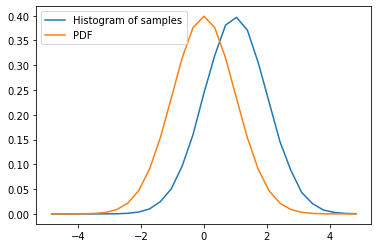

In [802]:
bins = np.linspace(-5, 5, 30)
samples = mvn.sample([100_000,])
histogram, bins = np.histogram(samples, bins=bins, density=True)

bin_centers = 0.5*(bins[1:] + bins[:-1])
print("bin_centers", bin_centers)
from matplotlib import pyplot as plt
plt.figure(figsize=(6, 4))
plt.plot(bin_centers, histogram, label="Histogram of samples")

from scipy import stats
pdf = stats.norm.pdf(bin_centers)

plt.plot(bin_centers, pdf, label="PDF")
plt.legend()
plt.show()

In [801]:
stats.norm?

Signature:       stats.norm(*args, **kwds)
Type:            norm_gen
String form:     <scipy.stats._continuous_distns.norm_gen object at 0x7f9d61257b10>
File:            ~/miniconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py
Docstring:      
A normal continuous random variable.

The location (``loc``) keyword specifies the mean.
The scale (``scale``) keyword specifies the standard deviation.

As an instance of the `rv_continuous` class, `norm` object inherits from it
a collection of generic methods (see below for the full list),
and completes them with details specific for this particular distribution.

Methods
-------
rvs(loc=0, scale=1, size=1, random_state=None)
    Random variates.
pdf(x, loc=0, scale=1)
    Probability density function.
logpdf(x, loc=0, scale=1)
    Log of the probability density function.
cdf(x, loc=0, scale=1)
    Cumulative distribution function.
logcdf(x, loc=0, scale=1)
    Log of the cumulative distribution function.
sf(x, loc=0, scale=1)

In [1734]:
def getTargetMeanEffect(PD: Tensor, rrTarget: Tensor):
        norm = N(0, 1)
        pdThresh = norm.icdf(1 - PD)
        pdTarget = PD * rrTarget
        print("pdThresh", pdThresh)
        print("pdTarget", pdTarget)
        pdvthresh = norm.icdf(1 - pdTarget)
        print("pdvthresh", pdvthresh)
        meanEffect = pdThresh - pdvthresh
        print("meanEffect", meanEffect)
        return meanEffect


pDs = tensor([.01, .01])
meanEffectCovarianceScale = tensor(.01)
# No matter how I scale this, correlation will remain the same, great!
covShared = liabilityCovarianceMatrix * meanEffectCovarianceScale

meanEffectsAcrossAllGenes = getTargetMeanEffect(pDs[0:2], rrMeans)
effectGenerator = MVN(meanEffectsAcrossAllGenes, covShared)
allEffects = effectGenerator.sample([nGenes])

n = N(0, 1)
thresh1 = n.icdf(pDs[0])
thresh2 = n.icdf(pDs[1])
print("thresh1, thresh2", thresh1, thresh2)
print("cdf1", n.cdf(thresh1))
# Interesting; this PDBoth will shrink if there is more correlation between these traits
# if correlation is 0, then the cdf appears nearly additive, and if correlation close to 1, 
# the cdf appears nearly that of the larger of the two thresholds
pdBothGenerator = WrappedMVN(MVN(tensor([0, 0]), torch.eye(2)))
PDBoth = pdBothGenerator.cdf(tensor([thresh1, thresh2]))
print("PDBoth", PDBoth)
pd1Gen = N(-allEffects[:, 0], 1)
pd2Gen = N(-allEffects[:, 1], 1)
PD1GivenV = pd1Gen.cdf(thresh1)
PD2GivenV = pd2Gen.cdf(thresh2)
print("PD1GivenV", PD1GivenV.mean())
print("PD2GivenV", PD2GivenV.mean())
PDBothGivenV = []
print("liabilityCovarianceMatrix", liabilityCovarianceMatrix)
# liabilityCovarianceMatrix = torch.eye(2)
for i in range(nGenes):
    # There may be a vectorized way, but would need to bring scipy's cdf method into pytorch
    # scipy requires ndim == 1 on means
    # print(allEffects[i])
    mvn = MVN(-allEffects[i], torch.eye(2))
    mvnw = WrappedMVN(mvn)

    PDBothGivenV.append(mvnw.cdf(tensor([thresh1, thresh2])))

# Oddity in this model: the prevalence of the individual trait is not explicit
# it's something intermediate to PD1 and PD2
pdsCovarOnMean = torch.stack([PD1GivenV, PD2GivenV, tensor(PDBothGivenV)]).T

print("pdsCovarOnMean.mean(0)", pdsCovarOnMean.mean(0))
# This has ~0 covariacne for singel effets, and ~.6 correlation for one of the single effects with a joint effect
print("np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,1])\n", np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,1]))
print("np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,2])\n", np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,2]))

effectGeneratorSingle = MVN(meanEffectsAcrossAllGenes, tensor([ [.01, 0], [0, .01] ] ))
allEffects = effectGenerator.sample([nGenes])
pd1Gen = N(-allEffects[:, 0], 1)
pd2Gen = N(-allEffects[:, 1], 1)
PD1GivenV = pd1Gen.cdf(thresh1)
PD2GivenV = pd2Gen.cdf(thresh2)

pDsWithBoth = tensor([*pDs, PDBoth])
print("pDsWithBoth", pDsWithBoth)

# Now calculate the single effect cases
effectGenerator = MVN(meanEffectsAcrossAllGenes, torch.eye(covShared.shape[0]))
allEffects = effectGenerator.sample([nGenes])
pd1Gen = N(-allEffects[:, 0], 1)
pd2Gen = N(-allEffects[:, 1], 1)
PD1GivenV = pd1Gen.cdf(thresh1)
PD2GivenV = pd2Gen.cdf(thresh2)

pdvsGeneAffects1 = torch.stack([PD1GivenV, pDs[1].expand([nGenes]), PD1GivenV])
pdvsGeneAffects2 = torch.stack([pDs[0].expand([nGenes]), PD2GivenV, PD2GivenV])

nullAndEffectGeneArchitectures = torch.stack([pDsWithBoth.expand(pdvsGeneAffects1.T.shape).T, pdvsGeneAffects1, pdvsGeneAffects2, pdsCovarOnMean.T]).transpose(2, 0).transpose(1,2)

pdThresh tensor([2.3263, 2.3263])
pdTarget tensor([0.0300, 0.0500])
pdvthresh tensor([1.8808, 1.6449])
meanEffect tensor([0.4456, 0.6815])
thresh1, thresh2 tensor(-2.3263) tensor(-2.3263)
cdf1 tensor(0.0100)
PDBoth 9.999977041459245e-05
PD1GivenV tensor(0.0306)
PD2GivenV tensor(0.0508)
liabilityCovarianceMatrix tensor([[1.0000, 0.5000],
        [0.5000, 1.0000]])
pdsCovarOnMean.mean(0) tensor([0.0306, 0.0508, 0.0016], dtype=torch.float64)
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,1])
 [[1.         0.49226265]
 [0.49226265 1.        ]]
np.corrcoef(pdsCovarOnMean[:,0], pdsCovarOnMean[:,2])
 [[1.         0.86909635]
 [0.86909635 1.        ]]
pDsWithBoth tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)


In [1228]:
mvn = MVN(allEffects[i], liabilityCovarianceMatrix)
mvnw = WrappedMVN(mvn)
g
mvnw.cdf(tensor([1.68]))

ValueError: unexpected array size: new_size=2, got array with arr_size=1


In [957]:
nullAndEffectGeneArchitectures = torch.stack([pDsWithBoth.expand(pdvsGeneAffects1.T.shape).T, pdvsGeneAffects1, pdvsGeneAffects2, pdsCovarOnMean.T]).transpose(2, 0).transpose(1,2)
nullAndEffectGeneArchitectures

tensor([[[1.0000e-02, 1.0000e-02, 1.8706e-02],
         [5.3346e-04, 1.0000e-02, 5.3346e-04],
         [1.0000e-02, 2.5661e-03, 2.5661e-03],
         [4.0569e-02, 5.7694e-02, 8.6686e-02]],

        [[1.0000e-02, 1.0000e-02, 1.8706e-02],
         [7.5029e-01, 1.0000e-02, 7.5029e-01],
         [1.0000e-02, 1.5657e-01, 1.5657e-01],
         [2.0293e-02, 3.1718e-02, 4.7327e-02]],

        [[1.0000e-02, 1.0000e-02, 1.8706e-02],
         [7.3560e-02, 1.0000e-02, 7.3560e-02],
         [1.0000e-02, 4.3783e-02, 4.3783e-02],
         [2.1426e-02, 5.0329e-02, 6.5180e-02]],

        ...,

        [[1.0000e-02, 1.0000e-02, 1.8706e-02],
         [2.5201e-04, 1.0000e-02, 2.5201e-04],
         [1.0000e-02, 3.7563e-01, 3.7563e-01],
         [3.5282e-02, 5.0879e-02, 7.6552e-02]],

        [[1.0000e-02, 1.0000e-02, 1.8706e-02],
         [5.6128e-02, 1.0000e-02, 5.6128e-02],
         [1.0000e-02, 1.1230e-04, 1.1230e-04],
         [2.5982e-02, 4.6032e-02, 6.4835e-02]],

        [[1.0000e-02, 1.0000e-02, 1.

In [952]:
pDsWithBoth.expand(20_000)

RuntimeError: The expanded size of the tensor (20000) must match the existing size (3) at non-singleton dimension 0.  Target sizes: [20000].  Tensor sizes: [3]

In [944]:
pdvsGeneAffects2

tensor([[1.0000e-02, 1.0000e-02, 1.0000e-02,  ..., 1.0000e-02, 1.0000e-02,
         1.0000e-02],
        [2.5661e-03, 1.5657e-01, 4.3783e-02,  ..., 3.7563e-01, 1.1230e-04,
         1.8419e-01],
        [2.5661e-03, 1.5657e-01, 4.3783e-02,  ..., 3.7563e-01, 1.1230e-04,
         1.8419e-01]])

In [947]:
pdsCovarOnMean

tensor([[0.0406, 0.0577, 0.0867],
        [0.0203, 0.0317, 0.0473],
        [0.0214, 0.0503, 0.0652],
        ...,
        [0.0353, 0.0509, 0.0766],
        [0.0260, 0.0460, 0.0648],
        [0.0213, 0.0482, 0.0631]], dtype=torch.float64)

In [962]:
nullAndEffectGeneArchitectures[0,3]

tensor([0.0406, 0.0577, 0.0867], dtype=torch.float64)

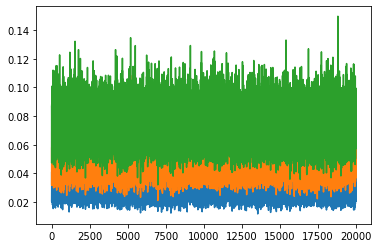

In [973]:
plt.plot(nullAndEffectGeneArchitectures[:, 3, :])

In [968]:
nullAndEffectGeneArchitectures[:, 0, :]

tensor([[0.0100, 0.0100, 0.0187],
        [0.0100, 0.0100, 0.0187],
        [0.0100, 0.0100, 0.0187],
        ...,
        [0.0100, 0.0100, 0.0187],
        [0.0100, 0.0100, 0.0187],
        [0.0100, 0.0100, 0.0187]], dtype=torch.float64)

In [1424]:
import pandas as pd

In [1682]:
dbs_data = pd.read_csv('/Users/alexkotlar/projects/tada/asd_adhd_both.csv')
dbs_data

Control_Total_PTV  ASD_Total  ADHD_Total  Both_Total
0                     4          7           5           5
1                     4          5           5           6
2                     1          5           1           1
3                     6          4           1           0
4                     0          2           0           2
...                 ...        ...         ...         ...
3177                 17          1           1           1
3178                 17          1           1           1
3179                 17          1           2           2
3180                 17          1           2           2
3181                 17          3           0           0

[3182 rows x 4 columns]

In [1683]:
dbs_data.sum()

Control_Total_PTV    25739
ASD_Total             3932
ADHD_Total            3302
Both_Total            3258
dtype: int64

In [1684]:
diseases

Index(['Control_Total_PTV', 'ASD_Total', 'ADHD_Total', 'Both_Total'], dtype='object')

In [1685]:
dbs_data = tensor(dbs_data.to_numpy(), dtype=torch.float32)

In [1686]:
dbs_data

tensor([[ 4.,  7.,  5.,  5.],
        [ 4.,  5.,  5.,  6.],
        [ 1.,  5.,  1.,  1.],
        ...,
        [17.,  1.,  2.,  2.],
        [17.,  1.,  2.,  2.],
        [17.,  3.,  0.,  0.]])

In [1562]:
dbs_data.mean(0)

tensor([8.0889, 1.2357, 0.2844, 1.0239])

In [1563]:
nCtrls = tensor(49781.)
nCases = tensor([3091. + 871, 3206. + 271, 684. + 217])
# https://www.cdc.gov/ncbddd/adhd/data.html
# https://www.nimh.nih.gov/health/statistics/attention-deficit-hyperactivity-disorder-adhd.shtml
# 4.4% among adults for ADHD
pDs = tensor([.02, .2, .9 * .14])

In [1564]:
afMean = dbs_data.sum() / ( (nCtrls + nCases.sum()) * 2 * len(dbs_data))
# Per gene afMean
afMean

tensor(9.1472e-05)

In [1691]:
nCases

tensor([3962., 3477.,  901.])

In [1715]:
test_dbs_fit = likelihoods.fitFnBivariate(dbs_data, pDs, nCases, nCtrls)

torch.Size([3182, 4])
pDs in likelihoodBivariateFast tensor([0.0200, 0.2000, 0.1260])
n tensor([21., 20.,  8.,  ..., 22., 22., 20.])
altCountsShaped torch.Size([3182, 3, 4])
pdsAll tensor([0.8565, 0.0682, 0.0598, 0.0155])
pDS are tensor([0.8565, 0.0682, 0.0598, 0.0155])
altCounts are tensor([[ 4.,  7.,  5.,  5.],
        [ 4.,  5.,  5.,  6.],
        [ 1.,  5.,  1.,  1.],
        ...,
        [17.,  1.,  2.,  2.],
        [17.,  1.,  2.,  2.],
        [17.,  3.,  0.,  0.]])
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9cc1c27050>
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9cc1c27050>
fnArgs [0.049643334, 0.043872375, 0.012981511, 85.46572, 413.62012, 410.80533, 486.00134]


RuntimeError: The size of tensor a (3) must match the size of tensor b (4) at non-singleton dimension 1

In [1693]:
test_dbs_fit["params"]

[array([2.29659110e-01, 4.07345330e-13, 7.70340890e-01, 5.26900198e+02,
        1.04070591e+03, 1.22212801e+03, 4.66370716e+03])]

In [1708]:
test_dbs_fitTwoCluster = likelihoods.fitFnBivariateStacked(dbs_data, pDs, nCases, nCtrls)

torch.Size([3182, 4])
pDs in likelihoodBivariateFast tensor([0.0200, 0.2000, 0.1260])
n tensor([21., 20.,  8.,  ..., 22., 22., 20.])
pdsAll tensor([0.8565, 0.0682, 0.0598, 0.0155])
pDS are tensor([0.8565, 0.0682, 0.0598, 0.0155])
altCounts are tensor([[ 4.,  7.,  5.,  5.],
        [ 4.,  5.,  5.,  6.],
        [ 1.,  5.,  1.,  1.],
        ...,
        [17.,  1.,  2.,  2.],
        [17.,  1.,  2.,  2.],
        [17.,  3.,  0.,  0.]])
fnArgs,  [0.14466517, 414.87598, 438.72906]
fnArgs,  [0.08098736, 210.48436, 302.18378]
fnArgs,  [0.20398389, 351.9377, 296.31555]
fnArgs,  [0.12937328, 370.4345, 96.5395]
fnArgs,  [0.0727852, 193.04433, 446.42053]
fnArgs,  [0.16872124, 292.8499, 59.172115]
fnArgs,  [0.1375847, 146.65892, 159.39674]
fnArgs,  [0.26920015, 51.895084, 34.555912]
fnArgs,  [0.13995564, 472.68234, 341.44934]
fnArgs,  [0.22609048, 454.10852, 18.474085]
bestParamsSimple [0.0727852, 193.04433, 446.42053]
{'method': 'Nelder-Mead', 'options': {'maxiter': 20000, 'adaptive': True}}
too

ValueError: not enough values to unpack (expected 7, got 4)

In [1694]:
paramsNewA0 = []
llsNewA0 = []
for i in range(10):
    test_dbs_fitA0 = likelihoods.fitFnBivariate(dbs_data, pDs, nCases, nCtrls, old=False)
    paramsNewA0.append(test_dbs_fitA0["params"])
    llsNewA0.append(test_dbs_fitA0["lls"])
paramsNewA0 = tensor(paramsNewA0)
llsNewA0 = tensor(llsNewA0)

0.111786745, 0.023856178, 0.11220107, 324.47937, 126.9185, 453.7483, 115.85195]
ll tensor(15515.2100, dtype=torch.float64)
bestParams [0.17382006, 0.15137626, 0.011274008, 78.31313, 334.6952, 300.8799, 305.0296]
Running single-step optimization
{'method': 'Nelder-Mead', 'options': {'maxiter': 20000, 'adaptive': True}}
Epoch took 28.53311800956726
torch.Size([3182, 4])
pDs in likelihoodBivariateFast tensor([0.0200, 0.2000, 0.1260])
n tensor([21., 20.,  8.,  ..., 22., 22., 20.])
pdsAll tensor([0.8565, 0.0682, 0.0598, 0.0155])
pDS are tensor([0.8565, 0.0682, 0.0598, 0.0155])
altCounts are tensor([[ 4.,  7.,  5.,  5.],
        [ 4.,  5.,  5.,  6.],
        [ 1.,  5.,  1.,  1.],
        ...,
        [17.,  1.,  2.,  2.],
        [17.,  1.,  2.,  2.],
        [17.,  3.,  0.,  0.]])
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9cd364a4d0>
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9cd364a4d0>
fnArgs 

In [1695]:
paramsNewA0.mean(0)

tensor([[3.9214e-01, 1.4328e-01, 4.6006e-01, 6.0160e+05, 1.1706e+06, 1.5716e+06,
         6.2948e+06]], dtype=torch.float64)

In [1619]:
paramsNewA0.mean(0)

tensor([[6.3684e-02, 4.9780e-03, 8.7858e-01, 2.2204e+05, 1.0955e+06, 3.5926e+04,
         1.0801e+05]], dtype=torch.float64)

In [1616]:
paramsNewA0.mean(0)

tensor([[2.2019e-02, 1.1604e-05, 8.2580e-01, 1.1609e+03, 5.7108e+03, 1.9363e+02,
         8.5903e+02]], dtype=torch.float64)

In [1602]:
paramsNewA0.mean(0)

tensor([[1.6960e-01, 1.3059e-02, 7.0481e-01, 1.7544e+02, 3.5550e+02, 8.3303e+01,
         1.2878e+03]], dtype=torch.float64)

In [1588]:
paramsNew = []
llsNew = []
for i in range(10):
    test_dbs_fit = likelihoods.fitFnBivariate(dbs_data, pDs, nCases, nCtrls, old=False)
    paramsNew.append(test_dbs_fit["params"])
    llsNew.append(test_dbs_fit["lls"])

torch.Size([3182, 4])
pDs in likelihoodBivariateFast tensor([0.0200, 0.2000, 0.1260])
n tensor([16., 15.,  7.,  ..., 20., 20., 20.])
pDS are tensor([0.8565, 0.0682, 0.0598, 0.0155])
altCounts are tensor([[ 4.,  7.,  0.,  5.],
        [ 4.,  5.,  0.,  6.],
        [ 1.,  5.,  0.,  1.],
        ...,
        [17.,  1.,  0.,  2.],
        [17.,  1.,  0.,  2.],
        [17.,  3.,  0.,  0.]])
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9cd362a4d0>
In main function
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9cd362a4d0>
fnArgs [0.1801547, 0.23842695, 0.05120191, 153.03624, 473.02426, 349.05194, 116.89253]
ll tensor(12605.5859)
fnArgs [0.2559099, 0.1406994, 0.03533993, 396.6576, 295.6041, 272.09253, 463.0092]
ll tensor(14143.2295)
fnArgs [0.12752293, 0.06208645, 0.20385568, 7.2440076, 466.71317, 437.9524, 171.43939]
ll tensor(14657.9492)
fnArgs [0.13467872, 0.094289616, 0.24848594, 318.92697, 291.80112, 450.22617, 212

In [1591]:
paramsNewTensor = tensor(paramsNew)
paramsNewTensor.mean(0)

tensor([[2.2459e-01, 3.0035e-03, 7.2639e-01, 1.3337e+02, 2.7356e+02, 8.3002e+01,
         9.8252e+02]], dtype=torch.float64)

In [1707]:
paramsNew

[[array([7.88922771e-05, 1.85145316e-14, 9.99921108e-01, 7.24836415e+01,
         1.48818227e+02, 3.64263774e+01, 5.19505781e+02])],
 [array([1.67260748e-01, 1.82077650e-13, 8.32739252e-01, 3.43930608e+02,
         6.90054119e+02, 1.55747073e+02, 2.68770895e+03])],
 [array([1.20571414e-01, 2.82895390e-04, 8.79145690e-01, 2.09393241e+02,
         4.13097785e+02, 9.56445400e+01, 1.60400625e+03])],
 [array([1.12164523e-07, 3.35685636e-09, 5.71468163e-01, 2.62640887e+01,
         5.61841287e+01, 9.59945760e+00, 2.35161787e+02])],
 [array([1.86803217e-08, 3.02223501e-09, 9.69825012e-01, 7.49115548e+01,
         1.49458744e+02, 3.83257684e+01, 5.33330111e+02])],
 [array([8.07689103e-12, 9.94605919e-03, 9.88845472e-01, 1.20875796e+02,
         2.39168303e+02, 6.29619318e+01, 8.66178391e+02])],
 [array([1.58896470e-13, 1.92623488e-02, 9.80737651e-01, 1.22705438e+02,
         2.46157985e+02, 6.31405405e+01, 8.56254705e+02])],
 [array([9.57961899e-01, 5.43270781e-04, 4.12412154e-02, 4.80773106e+

In [ ]:
# now with alpha0 explicitly, no nulllikelihood model
paramsNew = []
llsNew = []
for i in range(10):
    test_dbs_fit = likelihoods.fitFnBivariate(dbs_data, pDs, nCases, nCtrls, old=False)
    paramsNew.append(test_dbs_fit["params"])
    llsNew.append(test_dbs_fit["lls"])

In [1575]:
print(test_dbs_fit["lls"])
test_dbs_fit["params"]

[11837.06652748869]


[array([4.70144579e-01, 5.53766230e-09, 2.03325549e-04, 1.63957201e+01,
        6.38472094e+01, 3.72755754e-05, 5.33300394e+00])]

In [1573]:
print(test_dbs_fit["lls"])
test_dbs_fit["params"]

[9707.5715607682]


[array([1.45705007e-01, 5.77136631e-12, 8.54294993e-01, 6.20600896e+03,
        1.14855807e+04, 2.04666326e+03, 5.24139141e+04])]

In [1567]:
test_dbs_fit["params"]

[array([1.45705007e-01, 5.77136631e-12, 8.54294993e-01, 6.20600896e+03,
        1.14855807e+04, 2.04666326e+03, 5.24139141e+04])]

In [1556]:
test_dbs_fit["params"]

[array([2.34933035e-06, 1.56948806e-02, 9.84302063e-01, 3.18157223e+07,
        6.19881394e+07, 5.76676929e+07, 6.06626290e+07])]

In [1551]:
test_dbs_fit["params"]

[array([8.46139726e-09, 1.47950664e-02, 9.85183519e-01, 2.17222092e+05,
        4.23243572e+05, 3.96320363e+05, 4.21472088e+05])]

In [1543]:
test_dbs_fit["lls"]

[9643.366543580518]

In [1696]:
params = []
lls = []
for i in range(10):
    test_dbs_fit_old = likelihoods.fitFnBivariate(dbs_data, pDs, nCases, nCtrls, old=True)
    params.append(test_dbs_fit_old["params"])
    lls.append(test_dbs_fit_old["lls"])

t64)
bestParams [0.08018105, 0.22706085, 0.20968273, 157.97763, 4.8231883, 256.30463, 341.8053]
Running single-step optimization
{'method': 'Nelder-Mead', 'options': {'maxiter': 20000, 'adaptive': True}}
Epoch took 21.356733083724976
torch.Size([3182, 4])
pDs in likelihoodBivariateFast tensor([0.0200, 0.2000, 0.1260])
n tensor([21., 20.,  8.,  ..., 22., 22., 20.])
pdsAll tensor([0.8565, 0.0682, 0.0598, 0.0155])
pDS are tensor([0.8565, 0.0682, 0.0598, 0.0155])
altCounts are tensor([[ 4.,  7.,  5.,  5.],
        [ 4.,  5.,  5.,  6.],
        [ 1.,  5.,  1.,  1.],
        ...,
        [17.,  1.,  2.,  2.],
        [17.,  1.,  2.,  2.],
        [17.,  3.,  0.,  0.]])
costFn <function likelihoodBivariateFast.<locals>.jointLikelihood at 0x7f9ce252edd0>
In main function
Running old
method nelder-mead costFn <function likelihoodBivariateFast.<locals>.jointLikelihoodOld at 0x7f9ce252e440>
fnArgs [0.25199366, 0.16271189, 0.060992196, 12.309281, 186.18709, 80.89242, 460.64816]
ll tensor(12840.317

In [1705]:
from statistics import NormalDist

NormalDist(mu=2.5, sigma=1).overlap(NormalDist(mu=5.0, sigma=1))
# 0.2112995473337106

[[array([8.12428230e-09, 5.00589761e-02, 3.28887946e-01, 2.16475232e+02,
         5.02451298e-05, 8.13794239e+02, 3.67189332e+02])],
 [array([3.46734978e-08, 8.81590184e-09, 6.47570372e-01, 2.67311331e+02,
         6.07490108e+02, 8.12925958e+02, 4.98768166e-01])],
 [array([3.07359575e-03, 3.29926887e-08, 6.33970398e-01, 2.65719105e+02,
         6.05486801e+02, 8.23227556e+02, 7.04687147e-05])],
 [array([4.28002955e-03, 1.20446579e-05, 6.41574663e-01, 9.01344078e+02,
         2.02770740e+03, 2.75649696e+03, 1.61780000e-05])],
 [array([9.64628421e-08, 1.86071962e-02, 6.16643826e-01, 2.62663457e+02,
         6.04539155e+02, 8.16721716e+02, 1.35246852e-04])],
 [array([1.07269930e-08, 1.49875590e-08, 6.42161656e-01, 7.31037661e+02,
         1.64066840e+03, 2.23787640e+03, 2.73018651e-04])],
 [array([6.44359402e-07, 3.15144818e-07, 6.60135752e-01, 4.02619741e+07,
         7.83141720e+07, 1.06013669e+08, 1.11836794e+07])],
 [array([1.36449276e-04, 8.31780267e-05, 6.48400277e-01, 1.15924061e+

In [1706]:
paramsTensor = tensor(params[0:8] + params[9:])
paramsTensor.mean(0)

tensor([[1.5425e-03, 7.6402e-03, 6.0735e-01, 4.4739e+06, 8.7023e+06, 1.1780e+07,
         1.2427e+06]], dtype=torch.float64)

In [1580]:
paramsTensor = tensor(params)
paramsTensor.mean(0)

tensor([[3.0554e-01, 3.0649e-03, 6.4285e-01, 4.0865e+02, 1.0787e+03, 2.5321e+02,
         1.3732e+01]], dtype=torch.float64)

In [1611]:
paramsTensor = tensor(params)
paramsTensor.mean(0)

tensor([[3.0554e-01, 3.0649e-03, 6.4285e-01, 4.0865e+02, 1.0787e+03, 2.5321e+02,
         1.3732e+01]], dtype=torch.float64)

In [1583]:
paramsTensor.std(0)

tensor([[3.4469e-01, 5.6268e-03, 3.6387e-01, 7.1828e+02, 1.7891e+03, 4.8282e+02,
         4.3397e+01]], dtype=torch.float64)

In [1613]:
paramsOldA0 = []
llsOldA0 = []
for i in range(10):
    test_dbs_fit_old = likelihoods.fitFnBivariate(dbs_data, pDs, nCases, nCtrls, old=True)
    paramsOldA0.append(test_dbs_fit_old["params"])
    llsOldA0.append(test_dbs_fit_old["lls"])
paramsOldA0 = tensor(paramsOldA0)
llsOldA0 = tensor(llsOldA0)

)
fnArgs [0.107717015, 0.004268478, 0.014328727, 327.05356, 187.69557, 453.54224, 201.92458]
ll tensor(15595.4461, dtype=torch.float64)
fnArgs [0.040743288, 0.06579375, 0.01744485, 380.56998, 444.75305, 126.95122, 146.3995]
ll tensor(14648.5118, dtype=torch.float64)
fnArgs [0.3179992, 0.090815604, 0.19439673, 490.1174, 496.94925, 416.59003, 6.11545]
ll tensor(16383.8634, dtype=torch.float64)
bestParams [0.040743288, 0.06579375, 0.01744485, 380.56998, 444.75305, 126.95122, 146.3995]
Running single-step optimization
{'method': 'Nelder-Mead', 'options': {'maxiter': 20000, 'adaptive': True}}
Epoch took 20.58343195915222
torch.Size([3182, 4])
pDs in likelihoodBivariateFast tensor([0.0200, 0.2000, 0.1260])
n tensor([16., 15.,  7.,  ..., 20., 20., 20.])
pDS are tensor([0.6540, 0.0200, 0.2000, 0.1260])
altCounts are tensor([[ 4.,  7.,  0.,  5.],
        [ 4.,  5.,  0.,  6.],
        [ 1.,  5.,  0.,  1.],
        ...,
        [17.,  1.,  0.,  2.],
        [17.,  1.,  0.,  2.],
        [17.,  3.

In [1614]:
paramsOldA0.mean(0)

tensor([[4.5182e-04, 2.7518e-01, 2.3770e-03, 2.1596e+01, 2.8736e+02, 3.1577e+02,
         1.5371e+02]], dtype=torch.float64)

In [1609]:
paramsOldA0.mean(0)

tensor([[2.7897e-01, 7.9365e-05, 1.2951e-01, 3.2779e+01, 1.3117e+02, 6.5905e+02,
         9.7639e+01]], dtype=torch.float64)

In [1605]:
paramsOldA0.mean(0)

tensor([[1.6321e-01, 2.1743e-03, 2.1344e-01, 5.6557e+01, 2.0186e+02, 1.2727e+02,
         1.7176e+02]], dtype=torch.float64)

In [1577]:
print(test_dbs_fit_old["lls"])
test_dbs_fit_old["params"]

[11050.879806015997]


[array([9.96595332e-01, 3.82338812e-13, 3.40466828e-03, 3.81163965e+01,
        1.19042315e+02, 2.34153489e+02, 6.81278797e+00])]

In [1569]:
print(test_dbs_fit_old["lls"])
test_dbs_fit_old["params"]

[10598.185890460561]


[array([2.42021198e-02, 1.21385759e-02, 9.63659304e-01, 1.29414236e+02,
        3.43582746e+02, 9.35705045e+01, 2.58966144e-11])]

In [1545]:
test_dbs_fit_old["lls"]

[9831.61476433047]

In [1528]:
test_dbs_fit_old["params"]

[array([2.02491908e-03, 5.45515742e-14, 9.97975081e-01, 5.87329741e+02,
        9.11190611e+01, 2.66092390e+01, 1.04155979e+03])]

In [1474]:
dbs_data.mean(0)

tensor([8.0889, 0.9381, 0.9507, 0.1974])

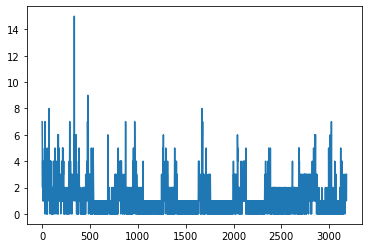

In [1532]:
plt.plot(dbs_data[:, 1])

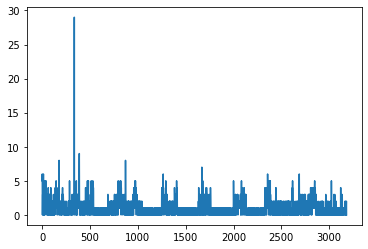

In [1531]:
plt.plot(dbs_data[:, 2])

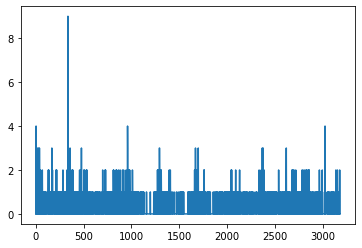

In [1530]:
plt.plot(dbs_data[:, 3])

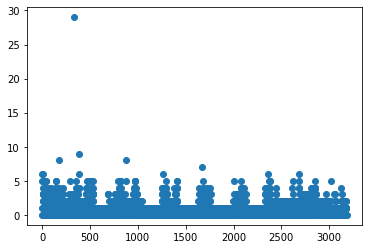

In [1667]:
plt.scatter(list(range(0, len(dbs_data))), dbs_data[:, 3])

In [1677]:
 dbs_data[:, 3].mean(0)

tensor(1.0239)

ModuleNotFoundError: No module named 'scipy.statistics'